In [1]:
import numpy as np
import yaml
from matplotlib import pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 

from utils.load_datasets import load_dataset
from models import vgg
from models.cvae import CVAE
from models.vgg_vmmix import BiternionVGGMixture

Using TensorFlow backend.


In [2]:
dataset_name = "CAVIAR-o" #"IDIAP" #"CAVIAR-o"
dataset_path = 'data/CAVIAR-o.pkl.gz' #'data//IDIAP.pkl' #'data/CAVIAR-o.pkl.gz' #
net_output = 'pan'
model_type = 'cvae'

In [3]:
(xtr, ytr_bit, ytr_deg), (xval, yval_bit, yval_deg), (xte, yte_bit, yte_deg) = load_dataset(dataset_name,
                                                                                            dataset_path,
                                                                                            net_output)

image_height, image_width, n_channels = xtr.shape[1], xtr.shape[2], xtr.shape[3]

In [5]:
if dataset_name=='CAVIAR-o' and model_type=='cvae':
    net_config_path = 'pretrained_models/CAVIAR-o/cvae/model.trial_3.params.yml'
    net_weights_path = 'pretrained_models/CAVIAR-o/cvae/model.trial_3.best.weights.hdf5'
elif dataset_name=='IDIAP' and model_type=='cvae':
    net_config_path = '/Users/sergey/BiternionNet/pretrained_models/IDIAP/cvae/model.trial_1.params.yml'
    net_weights_path = '/Users/sergey/BiternionNet/pretrained_models/IDIAP/cvae/model.trial_1.best.weights.hdf5'

In [13]:
with open(net_config_path, 'r') as f:
    net_config = yaml.load(f)

if model_type == 'vm_mixture':
    model = BiternionVGGMixture(image_height=image_height,
                            image_width=image_width,
                            n_channels=3,
                            **net_config)
    model.load_weights(net_weights_path)
    
elif model_type == 'cvae':
    model = CVAE(image_height=image_height,
                 image_width=image_width,
                 n_channels=n_channels,
                 **net_config)
    model.load_weights(net_weights_path)

In [27]:
model.evaluate(xte[0:100],yte_deg[0:100], 'test')

MAAD error (test) : 5.918852 pm 0.788678SEM
ELBO (test) : 0.604997 pm 0.172920SEM
Approx Log-Likelihood, importance sampling (test) : 0.606665 pm 0.172731SEM
KL-div (test) : 0.000092 pm0.000008SEM


{'elbo': 0.60499727249868673,
 'elbo_sem': array([ 0.17291991]),
 'importance_log_likelihood': 0.60666508304948419,
 'importance_log_likelihood_sem': 0.17273095397729243,
 'kl_div': 9.2405902905738911e-05,
 'kl_div_sem': array([  7.57462515e-06]),
 'maad_loss': 5.9188524741476831,
 'maad_loss_sem': 0.78867786373334614}

In [16]:
n_test_images = 100
n_samples = 20
xvals =  np.arange(0, 2*np.pi, 0.01)
cvae_samples_pdfs, cvae_acc_pdfs = model.pdf(xte[0:n_test_images], xvals, n_samples=n_samples)

In [10]:
def plot_pdf(axis, xvals, pdf, gt_val=None):
    
    axis.set_xticks(([0., .5*np.pi, np.pi, 1.5*np.pi, 2*np.pi]))
    axis.set_xticklabels(["$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"]) 
    axis.set_xlim([-0.001, 2*np.pi+0.001])
    axis.set_ylim([0, 10.0])
    if gt_val is not None:
        axis.axvline(gt_val, color='red')
    axis.plot(xvals, pdf)
    
    return

In [11]:
def plot_image_results(im, xvals, acc_pdf, samples_pdf, ytr_rad):

    fig, axs = plt.subplots(1, 3, figsize=(30, 5))

    axs[0].imshow(im)
    
    plot_pdf(axs[1], xvals, acc_pdf, ytr_rad)
    for sid in range(0, 20):
        plot_pdf(axs[2], xvals, samples_pdf[sid], ytr_rad)
    
    plt.show()
    
    return

In [30]:
dec_preds = model.get_multiple_decoder_predictions(xte[0:100])

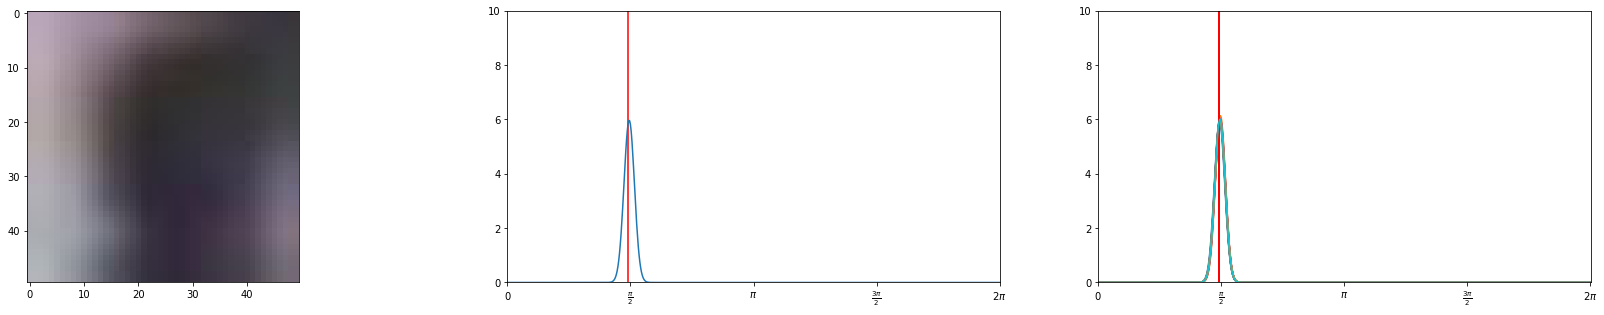

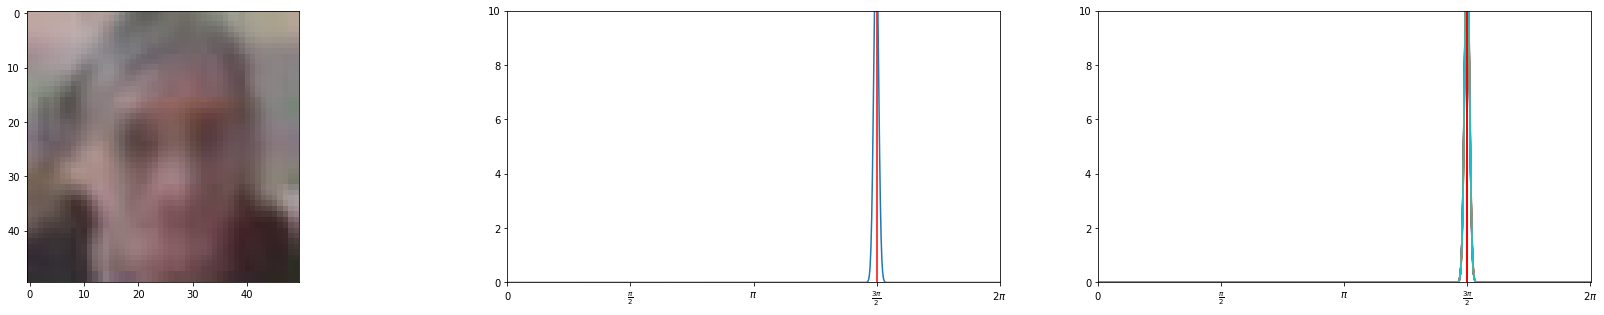

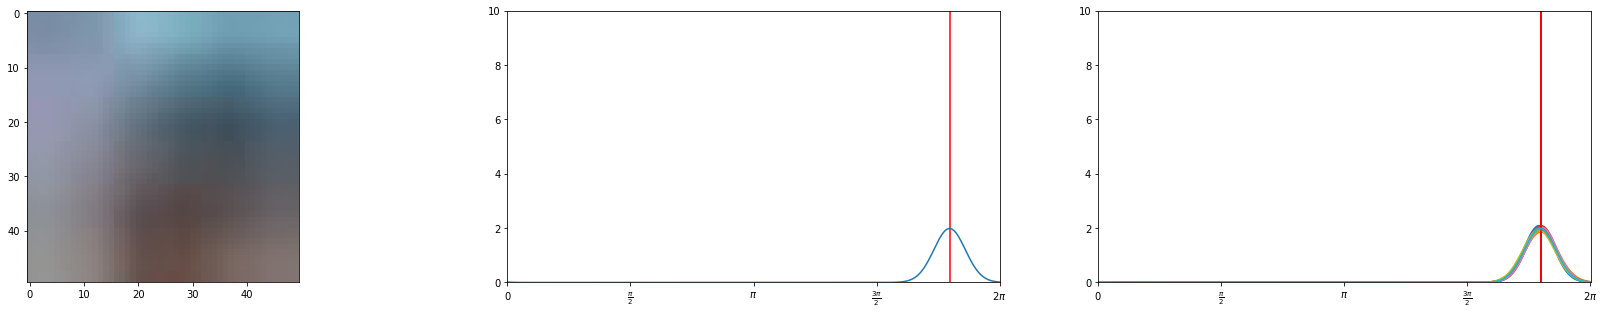

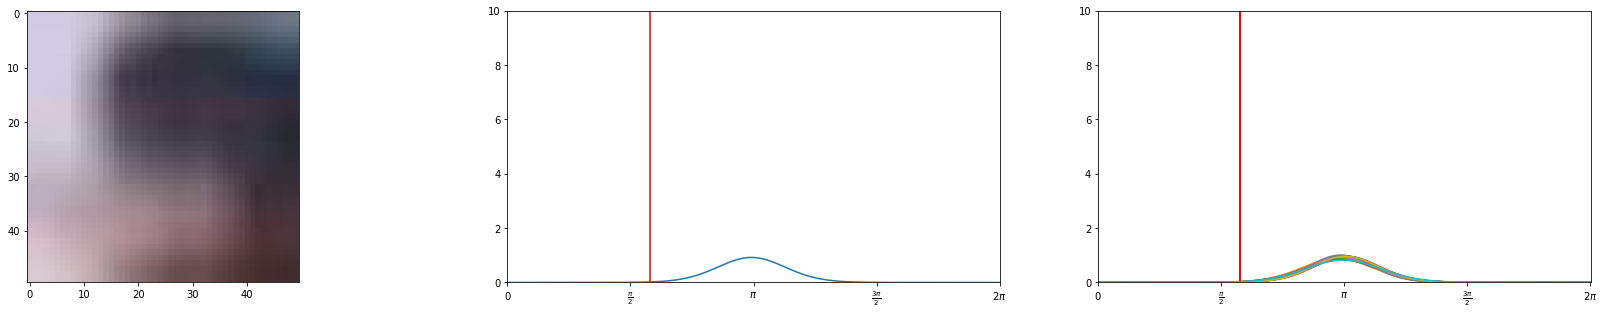

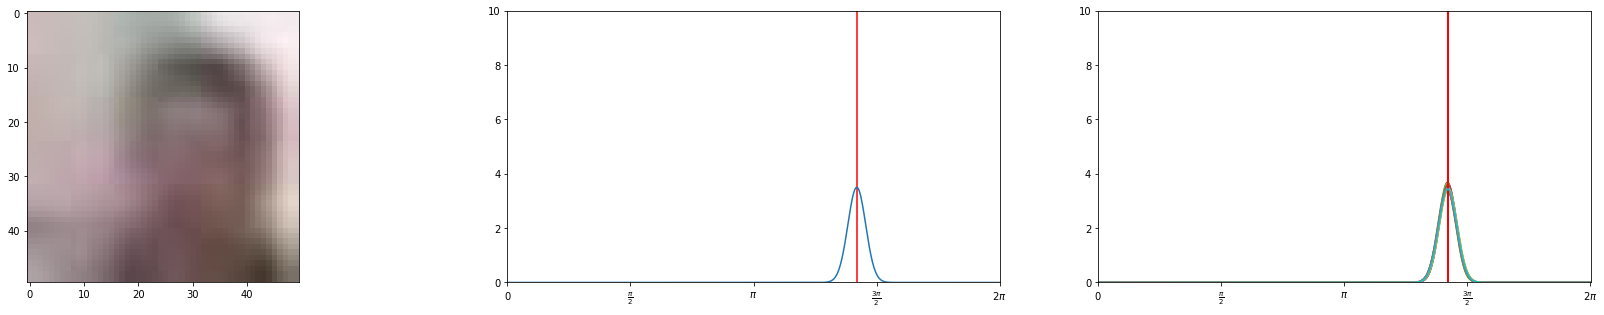

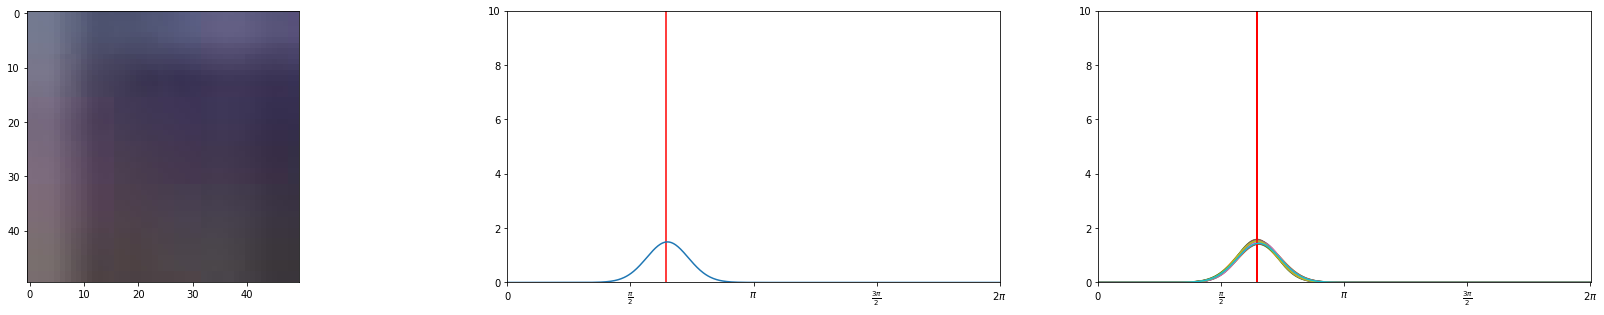

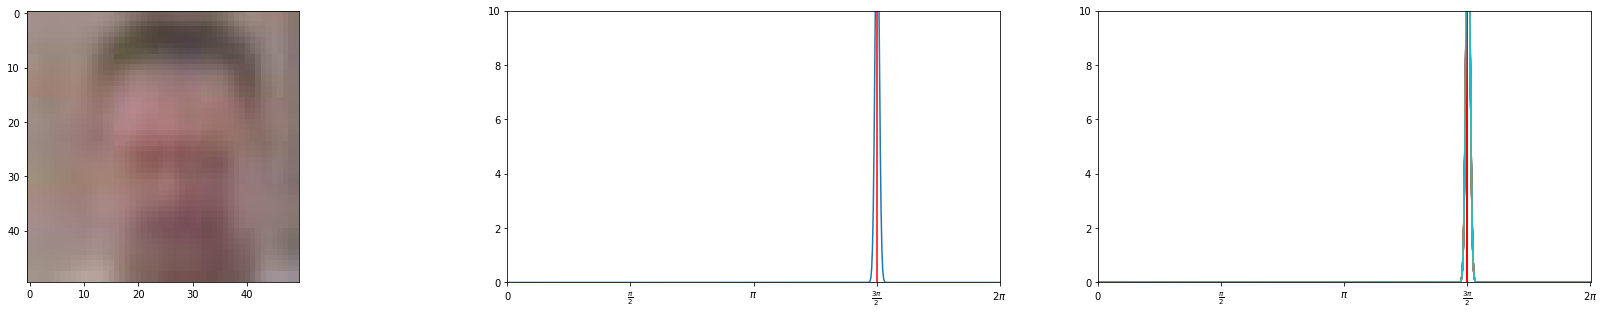

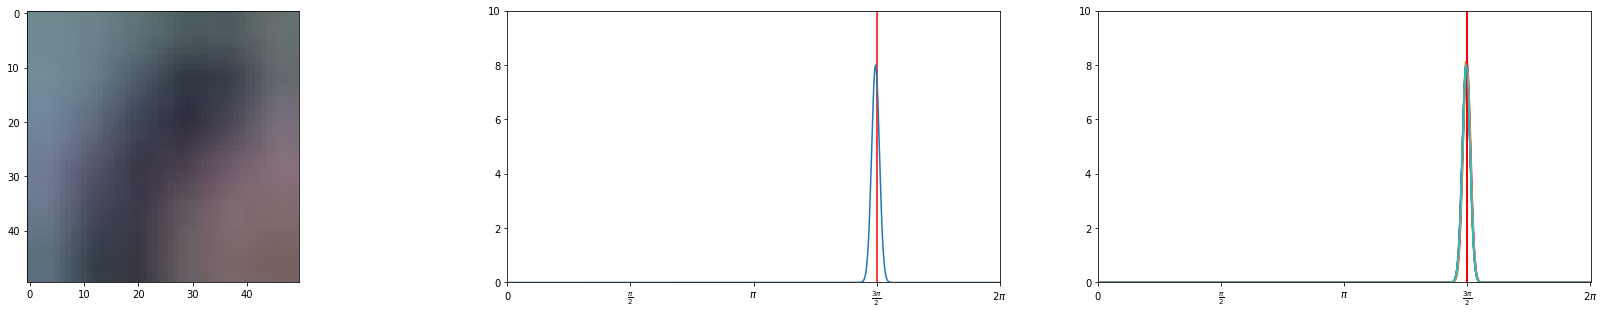

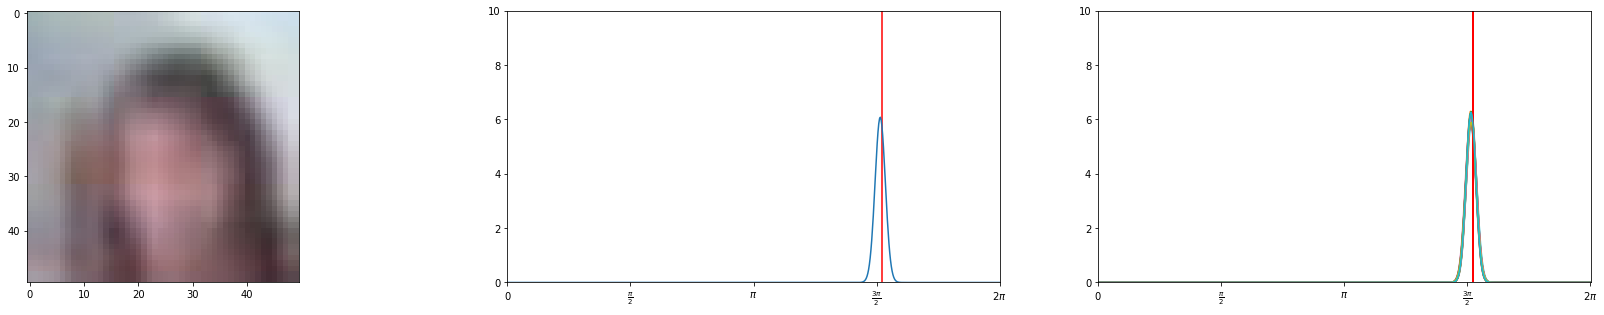

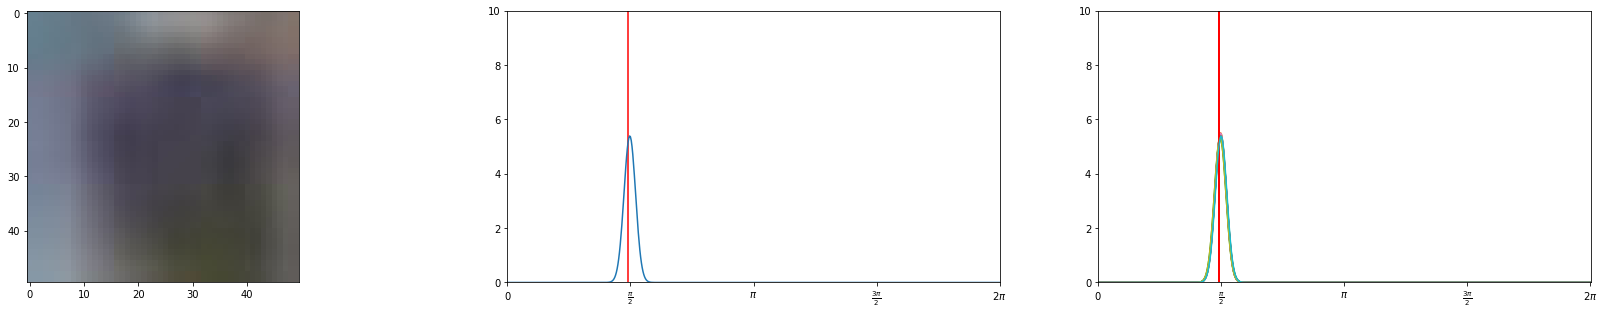

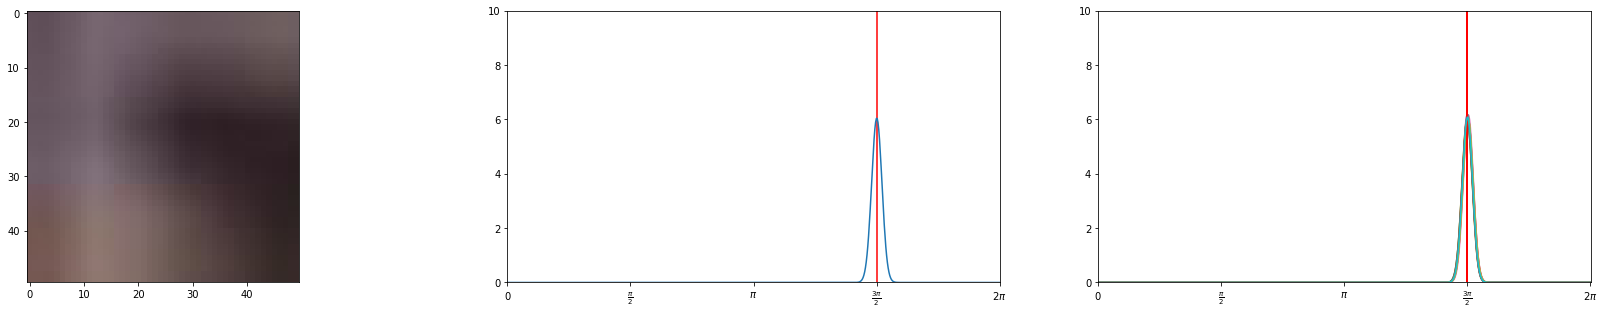

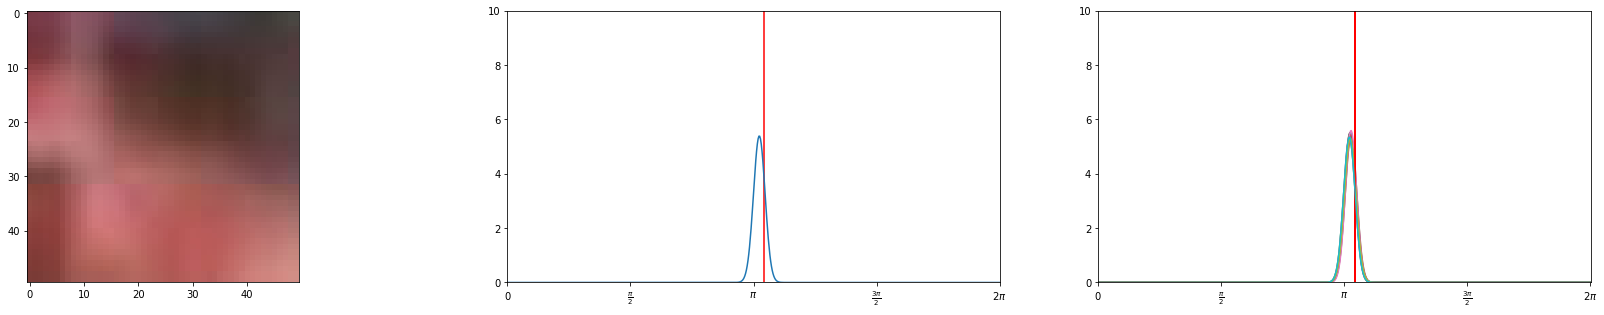

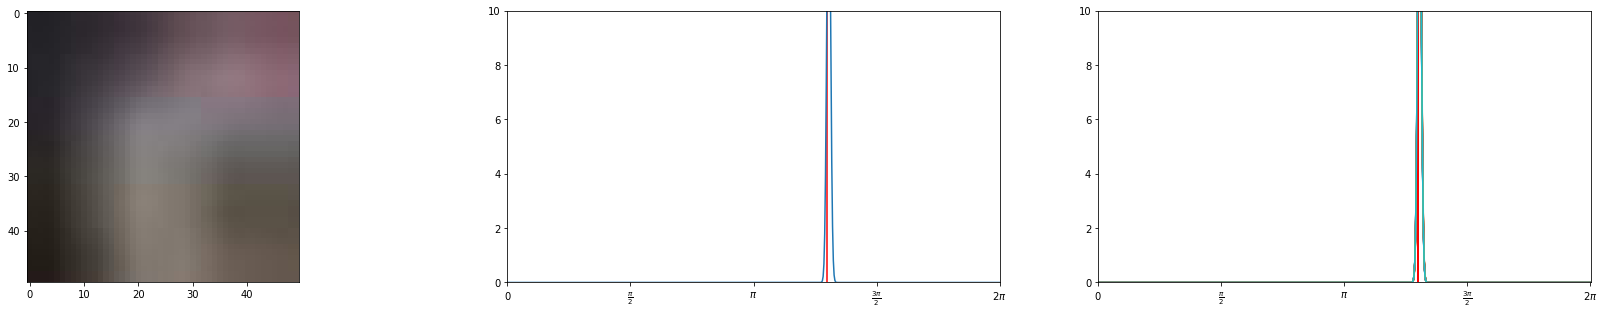

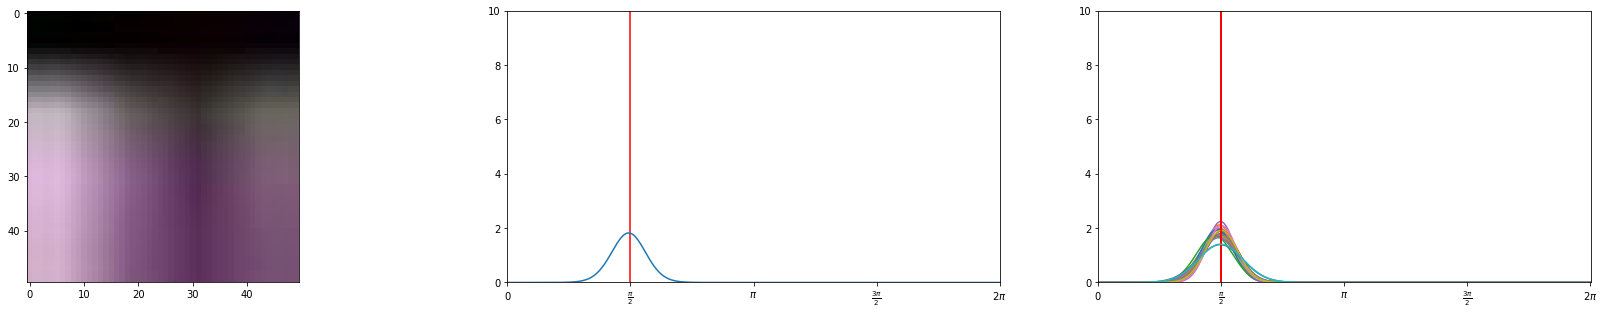

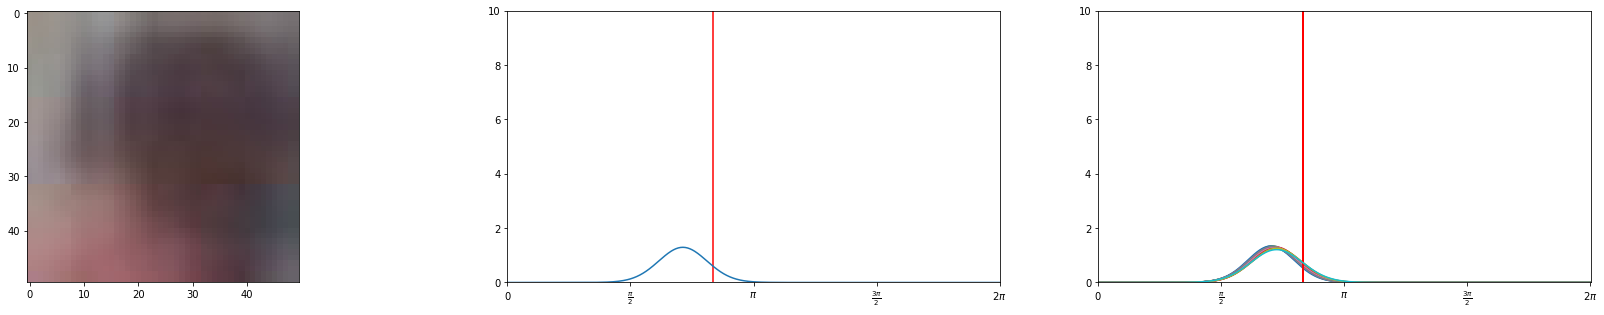

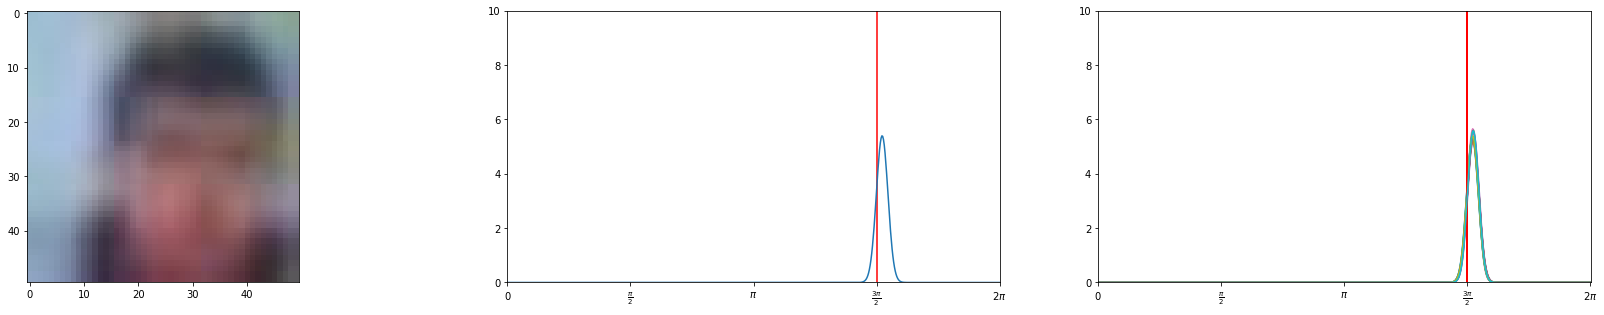

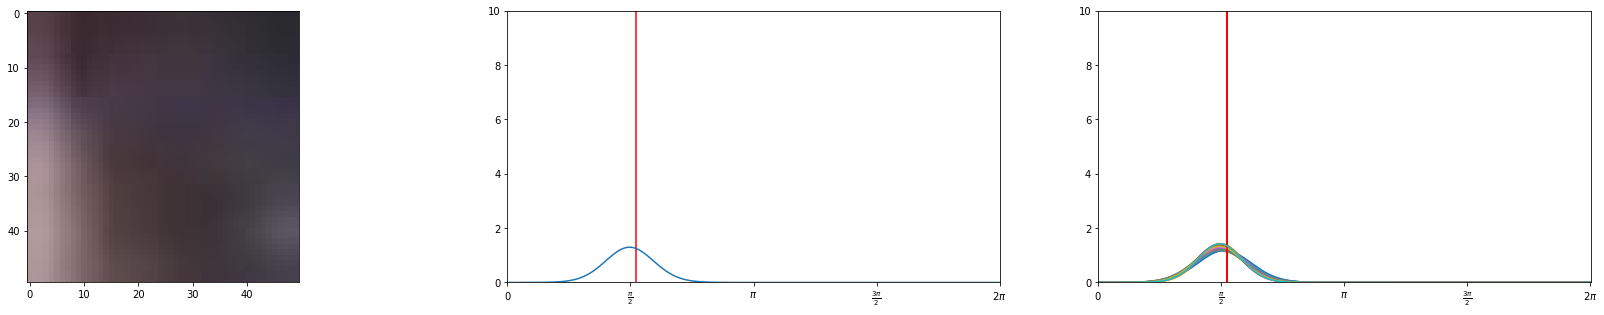

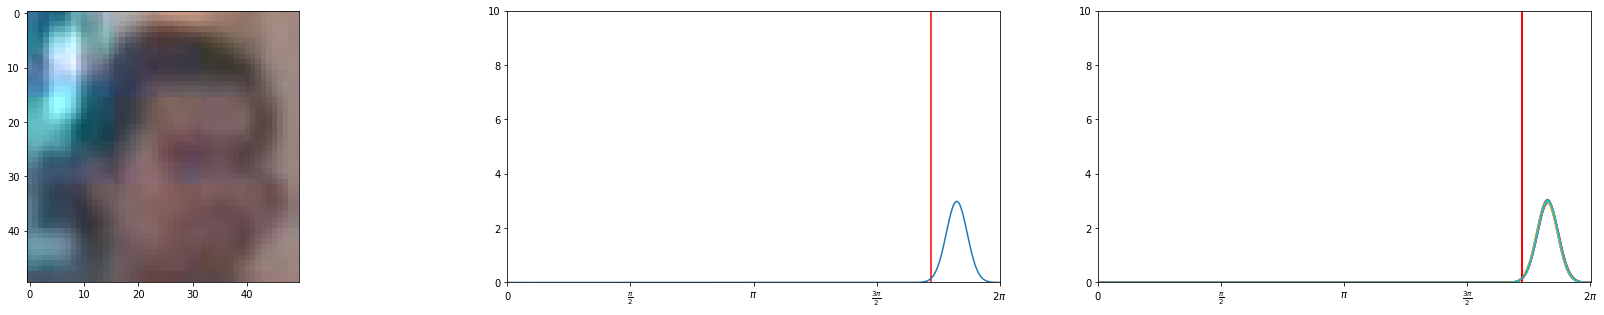

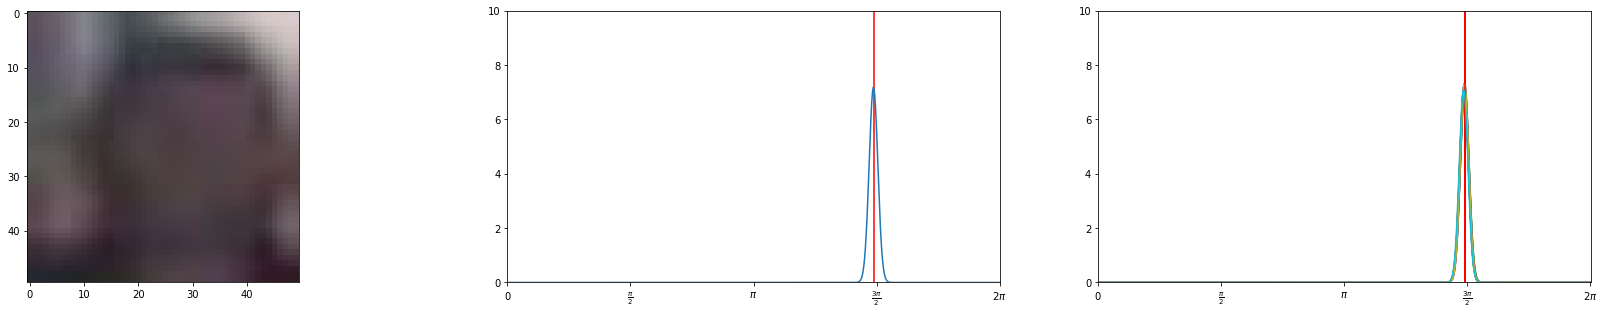

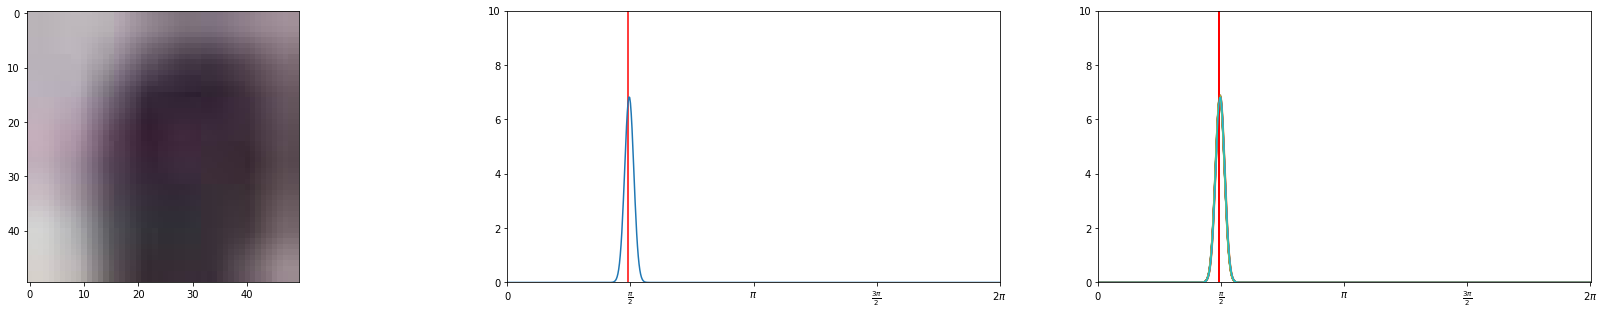

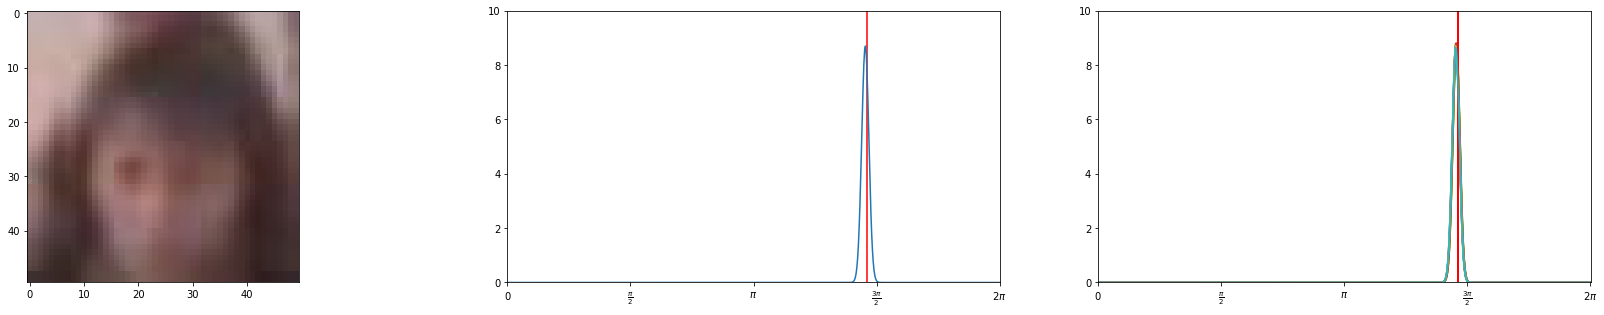

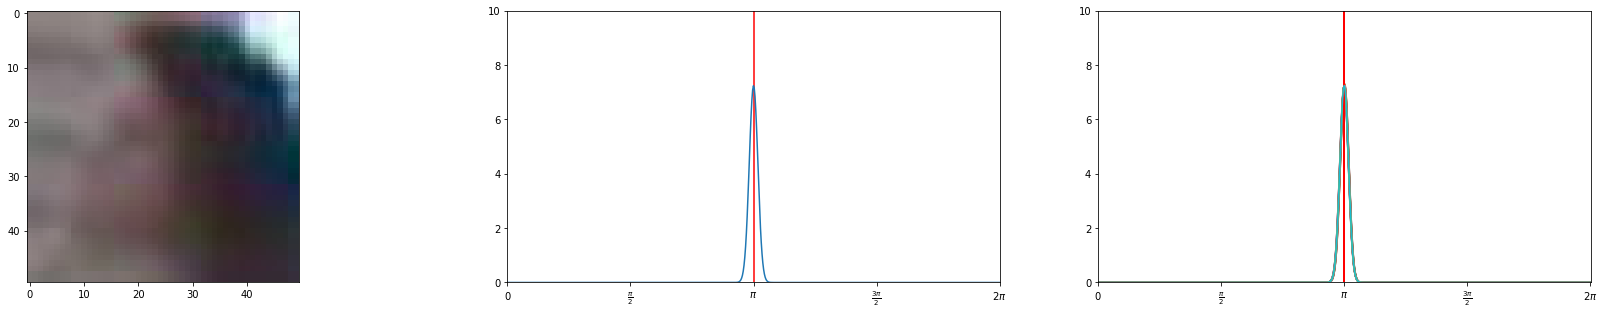

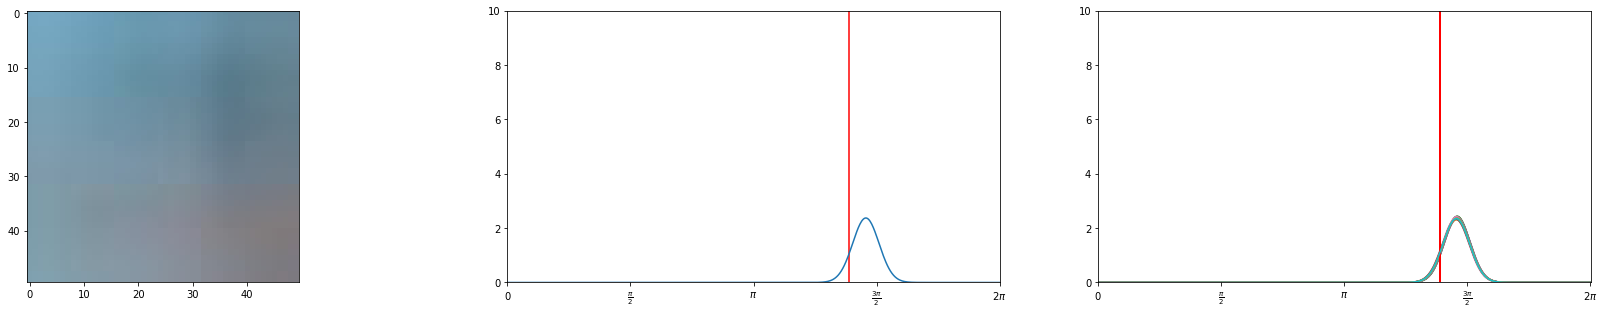

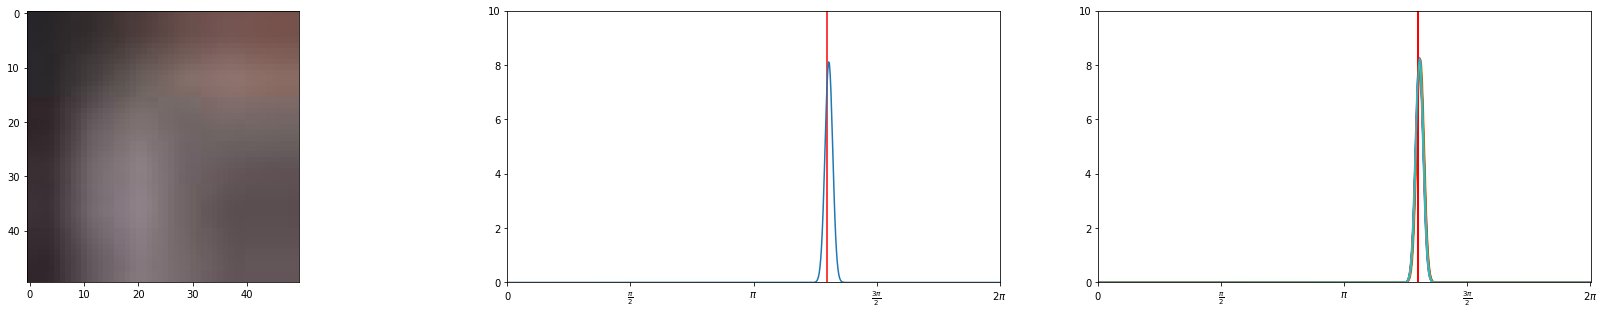

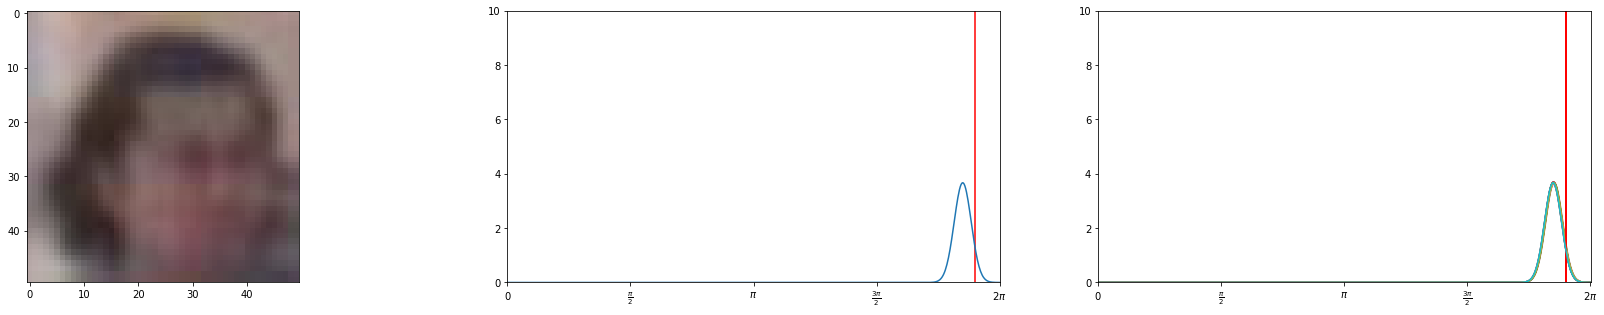

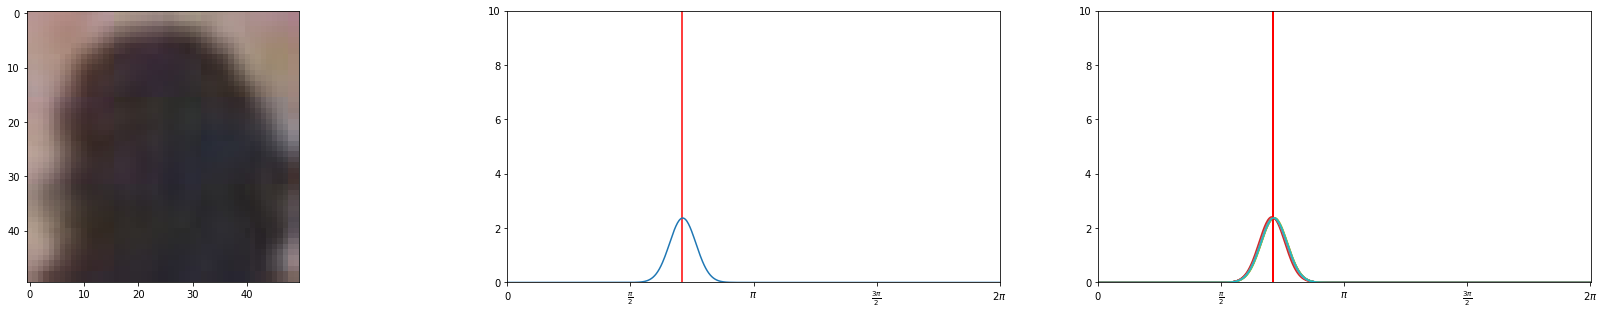

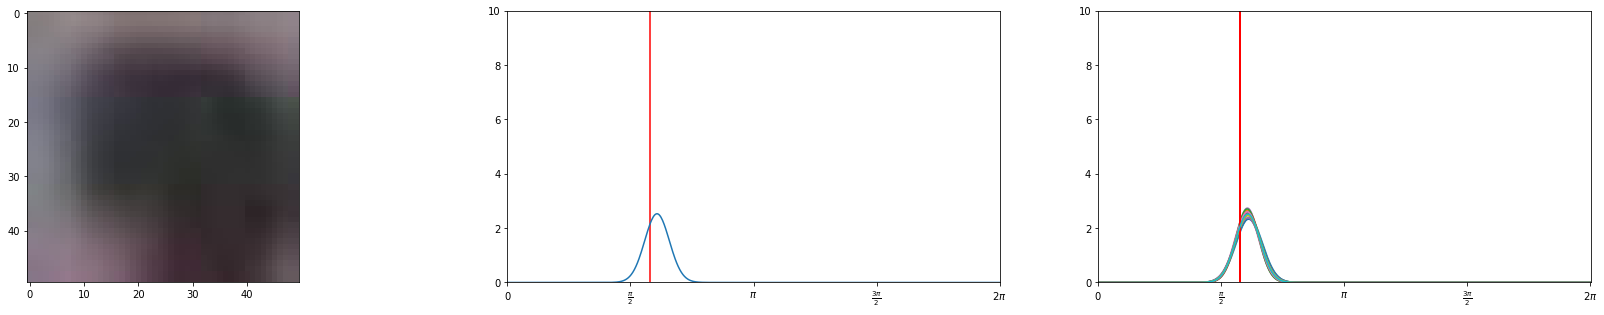

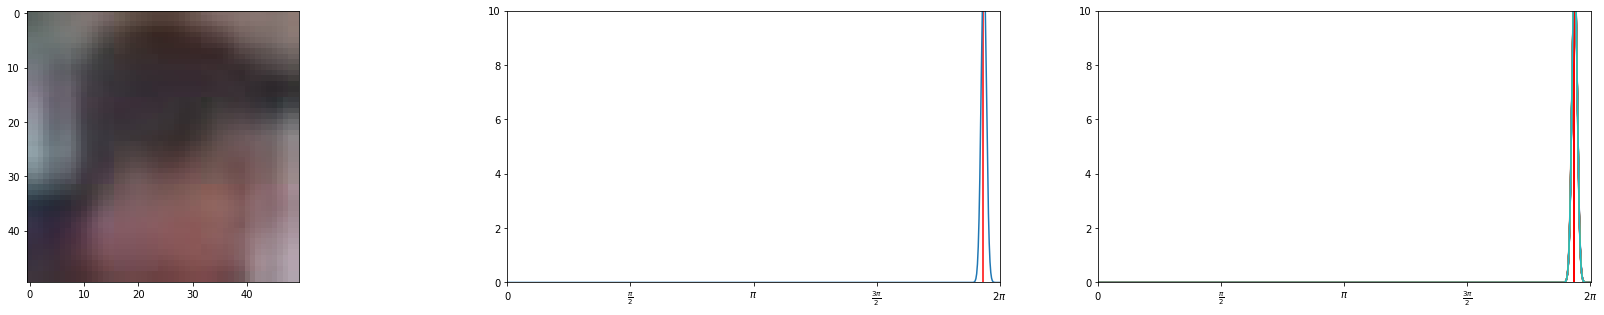

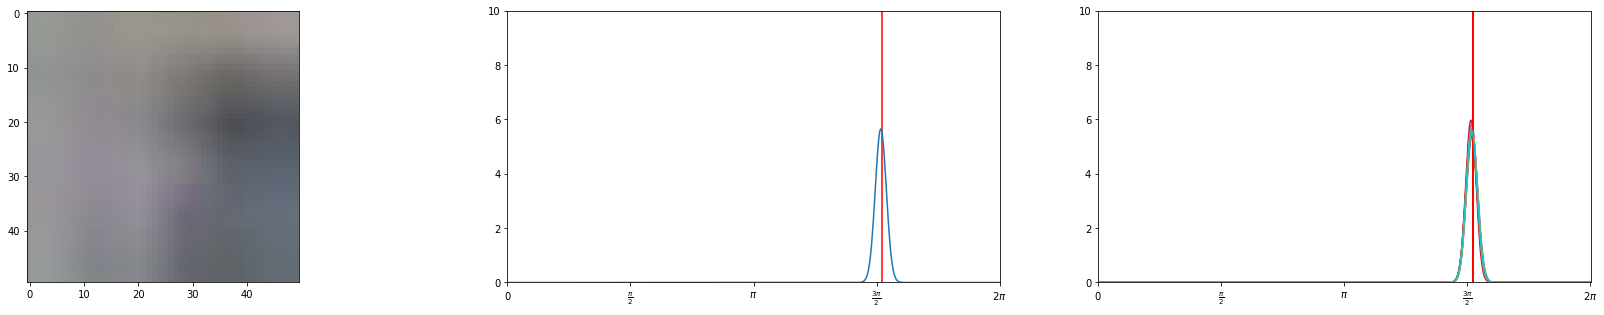

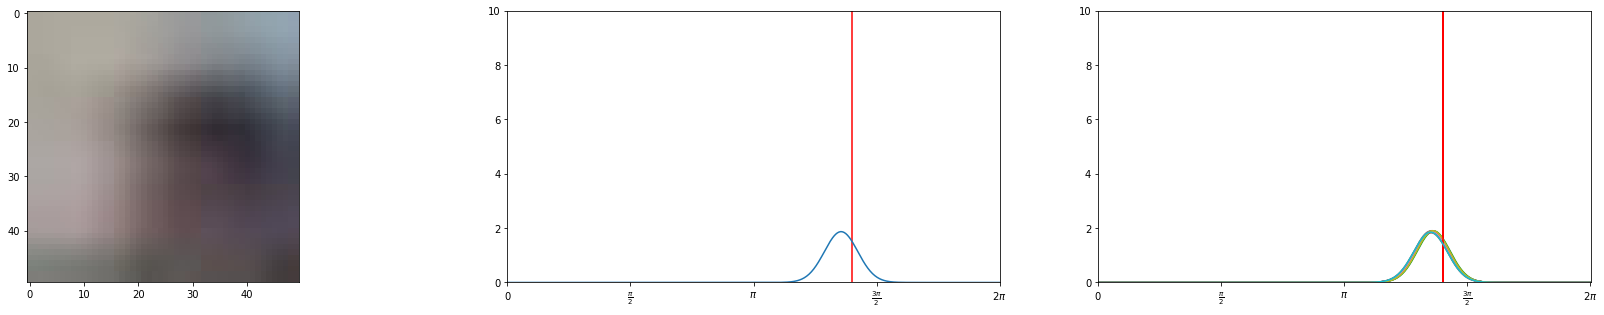

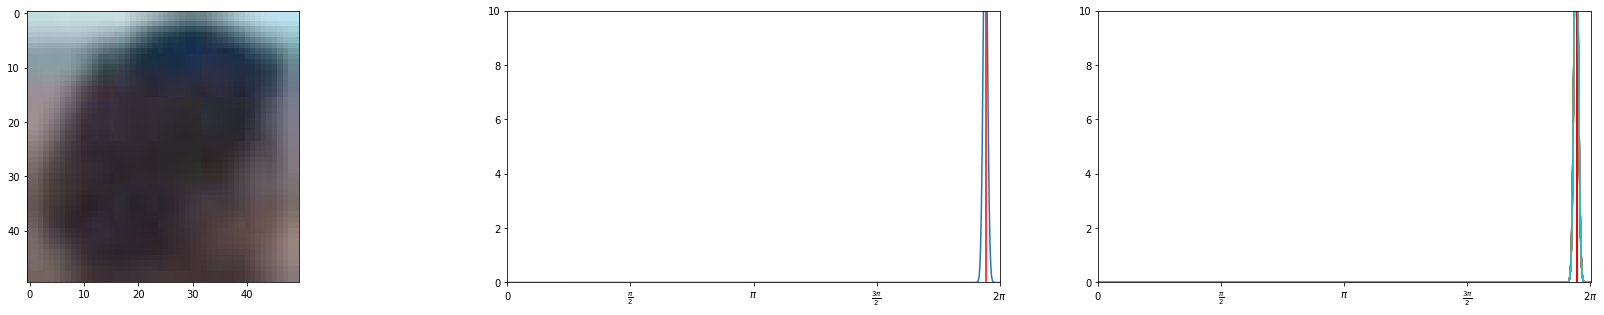

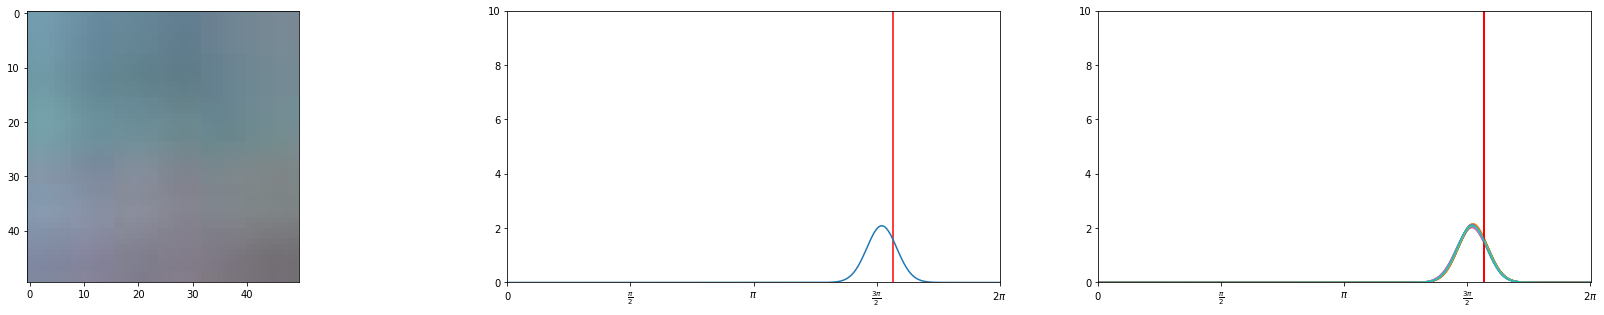

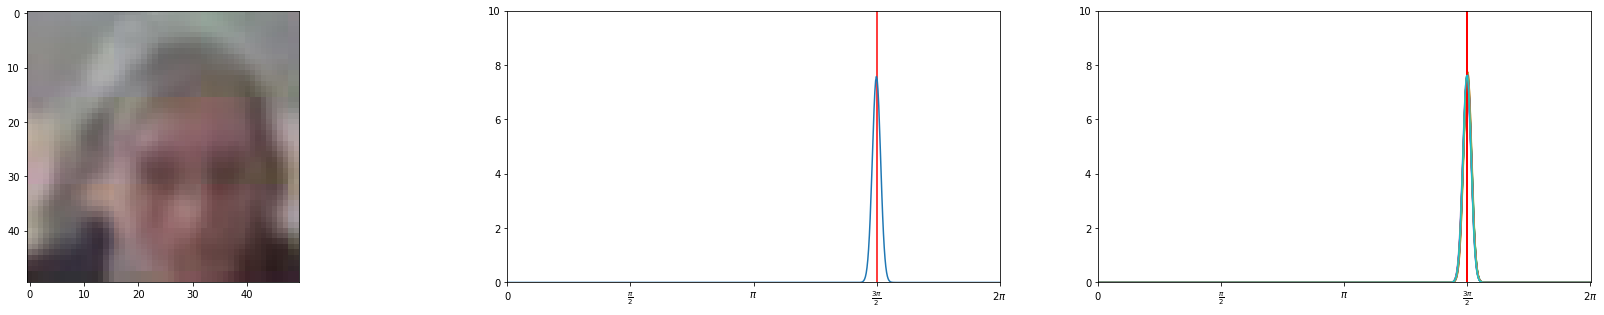

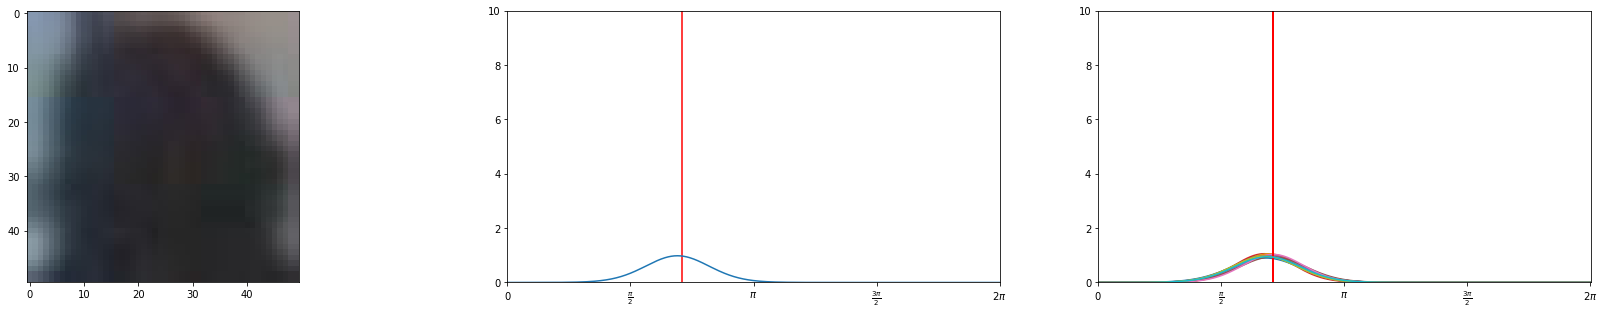

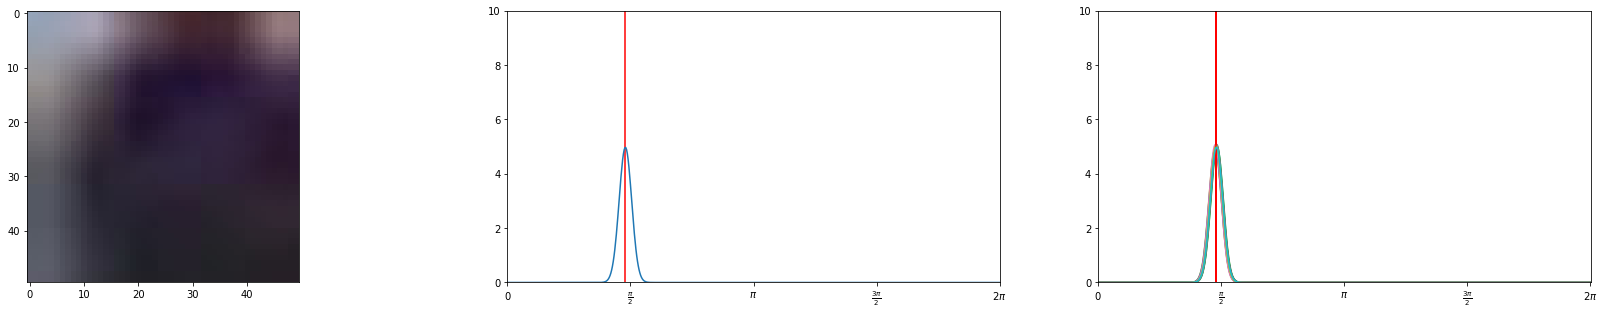

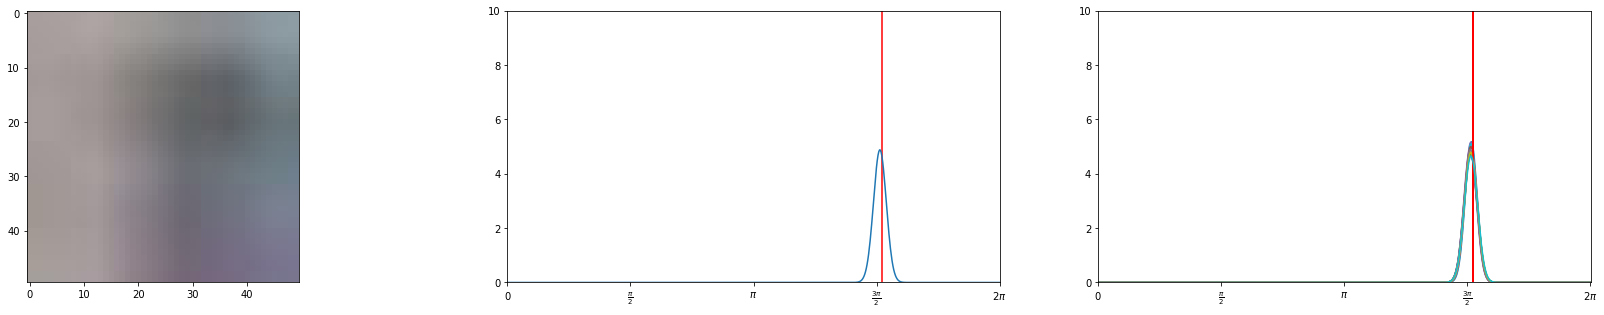

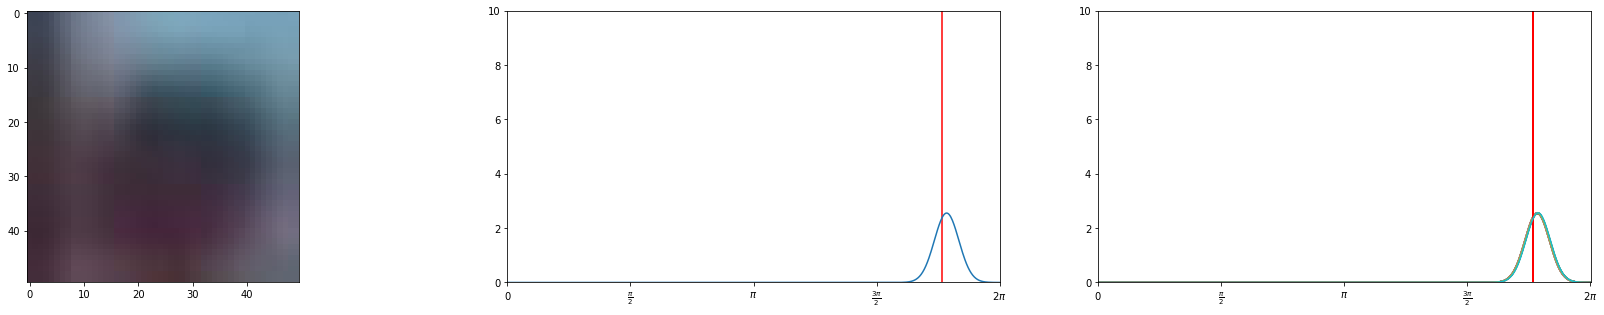

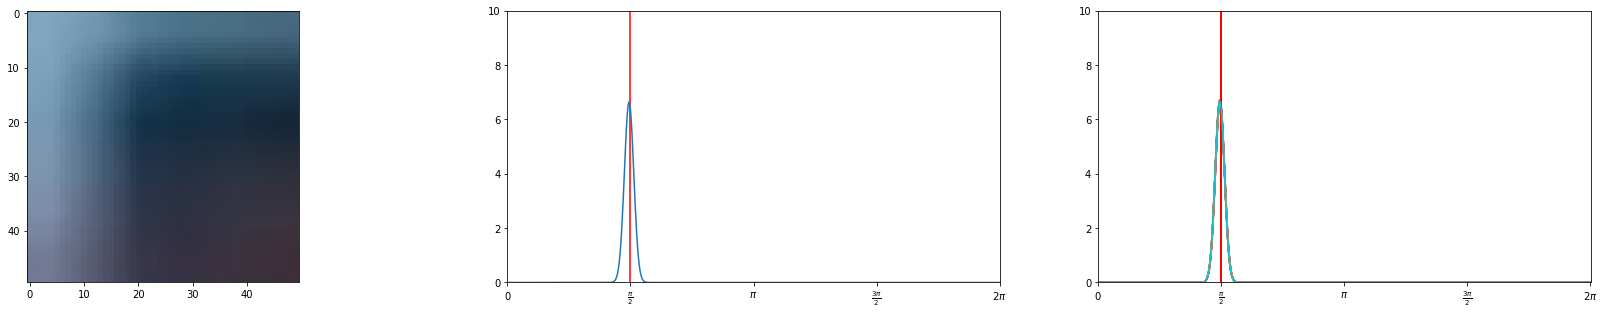

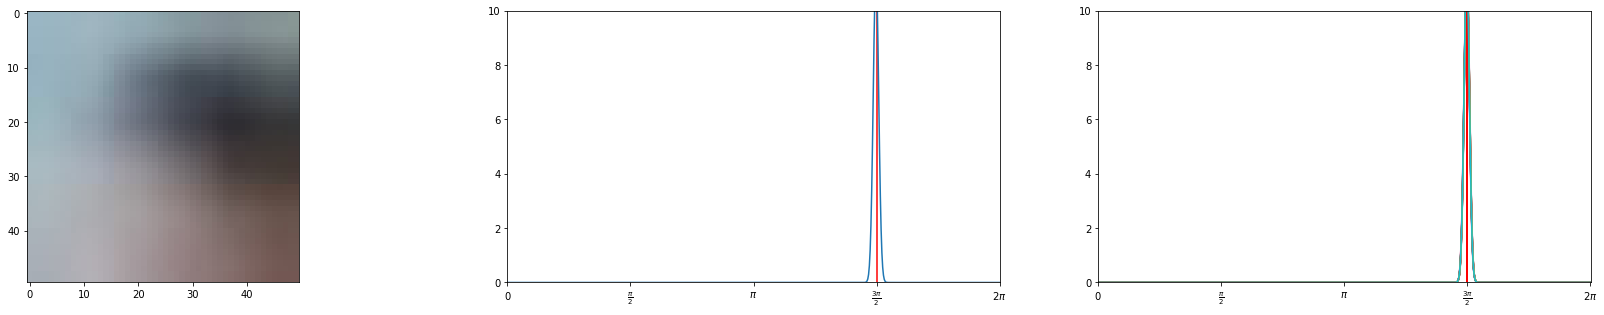

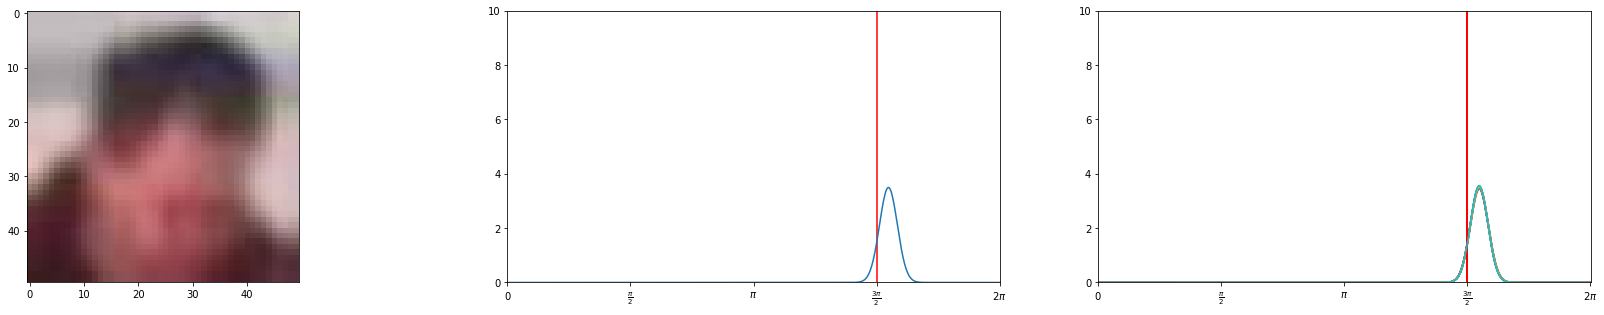

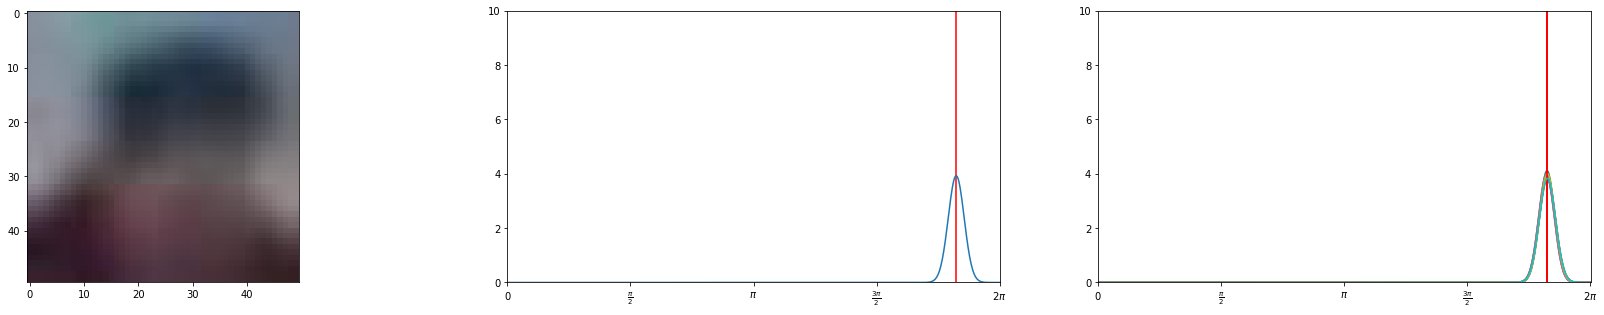

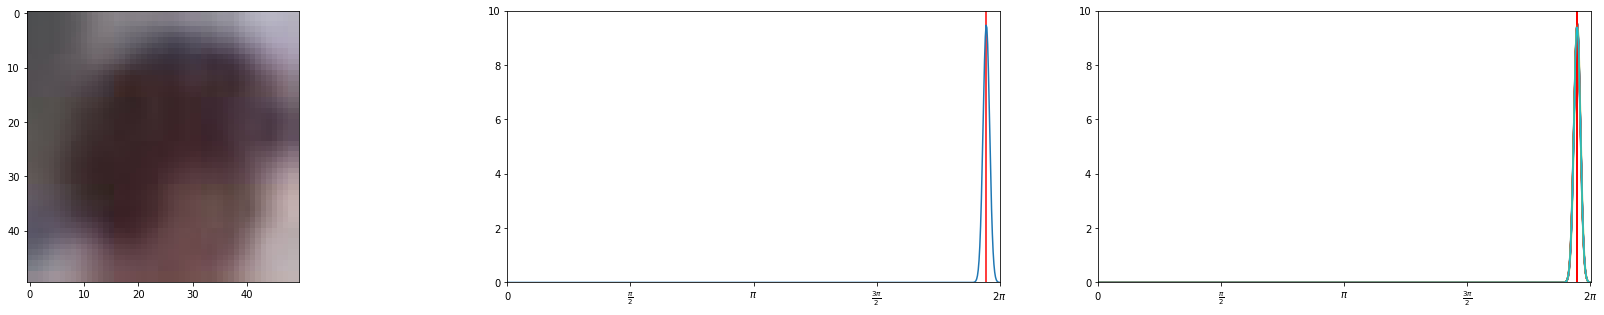

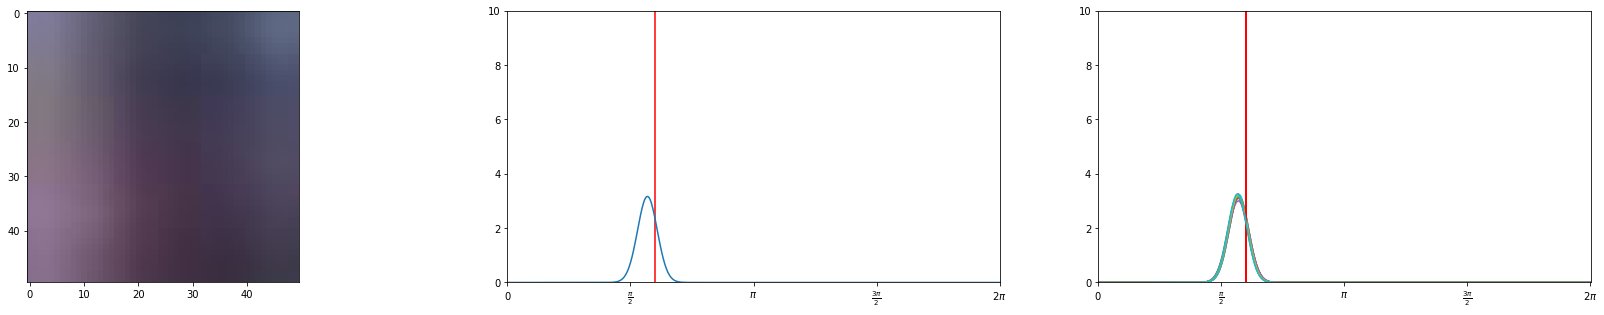

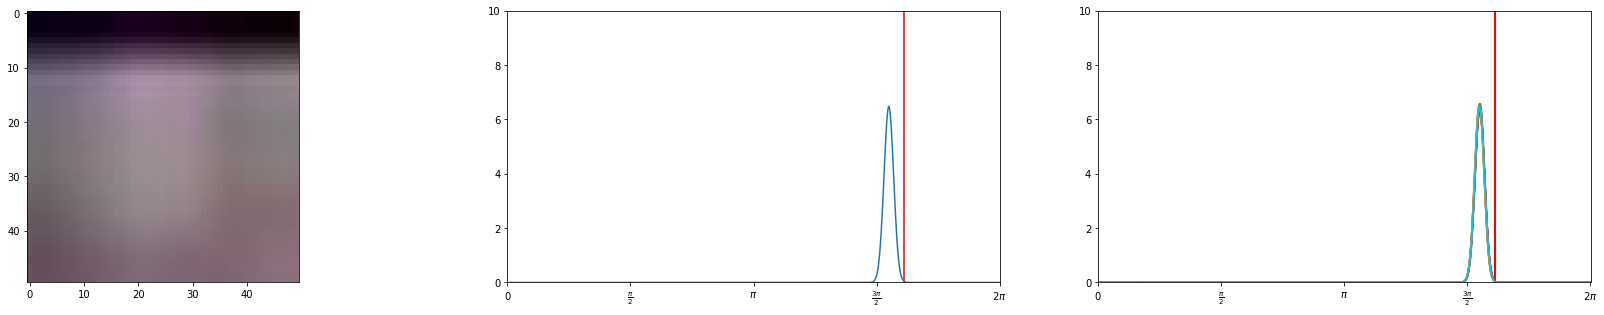

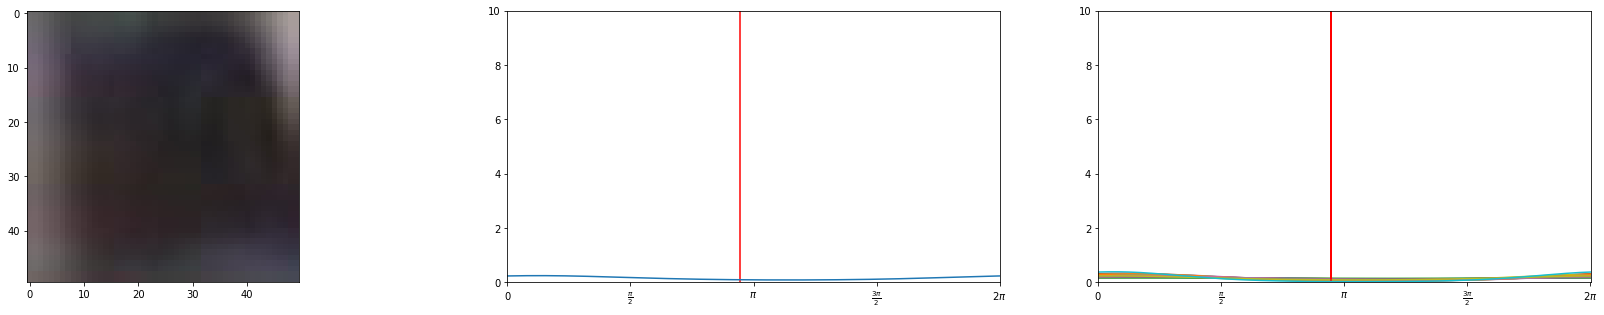

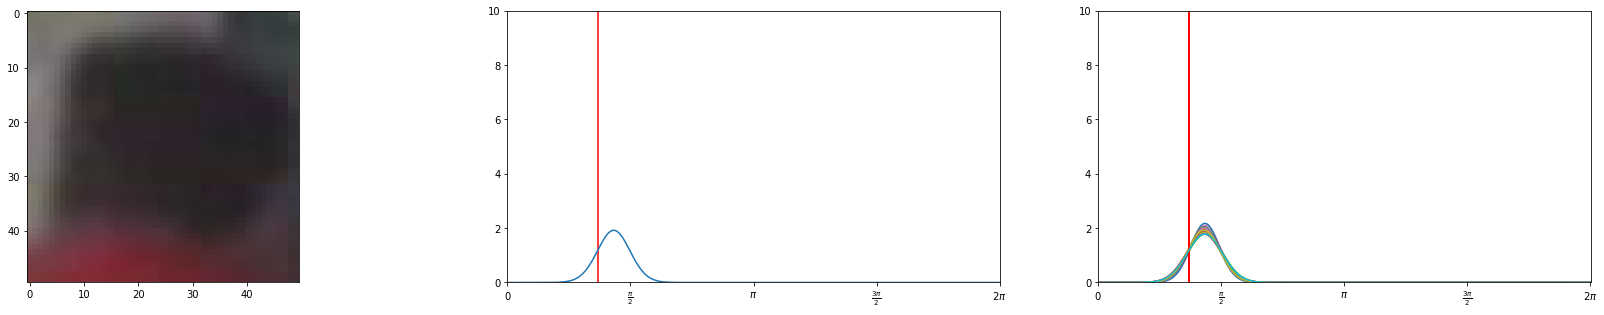

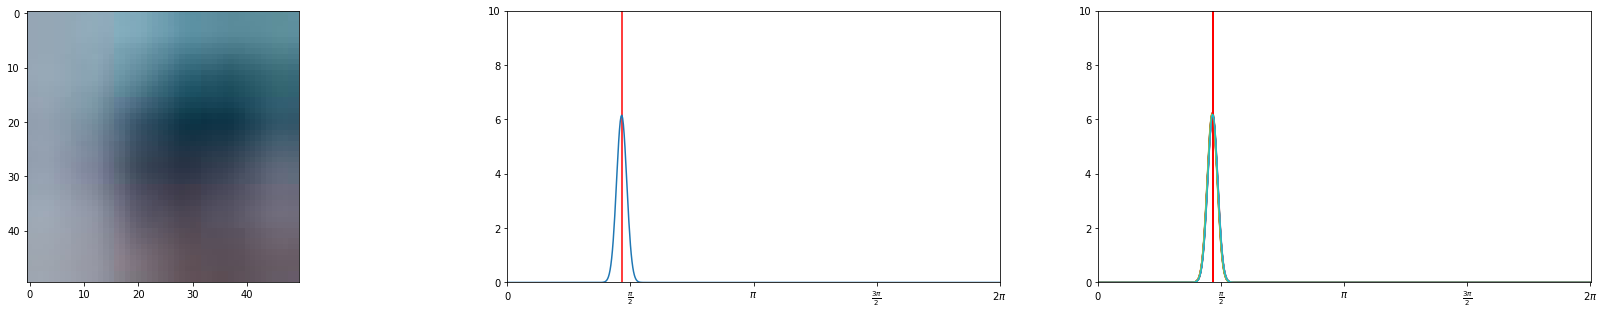

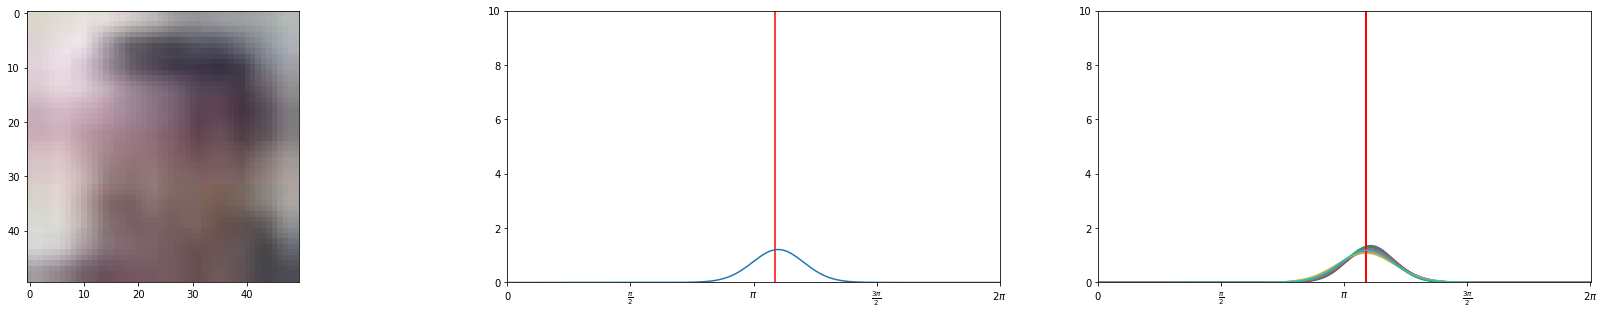

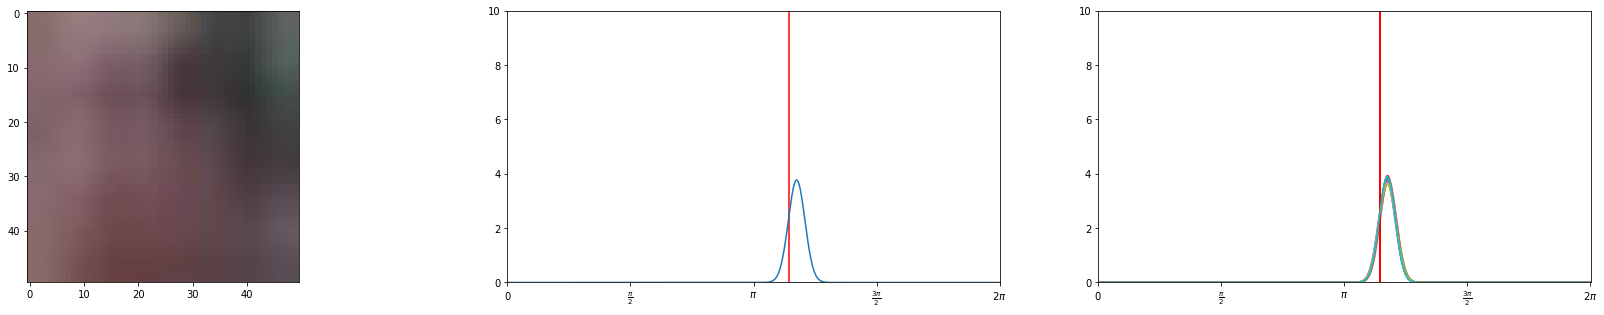

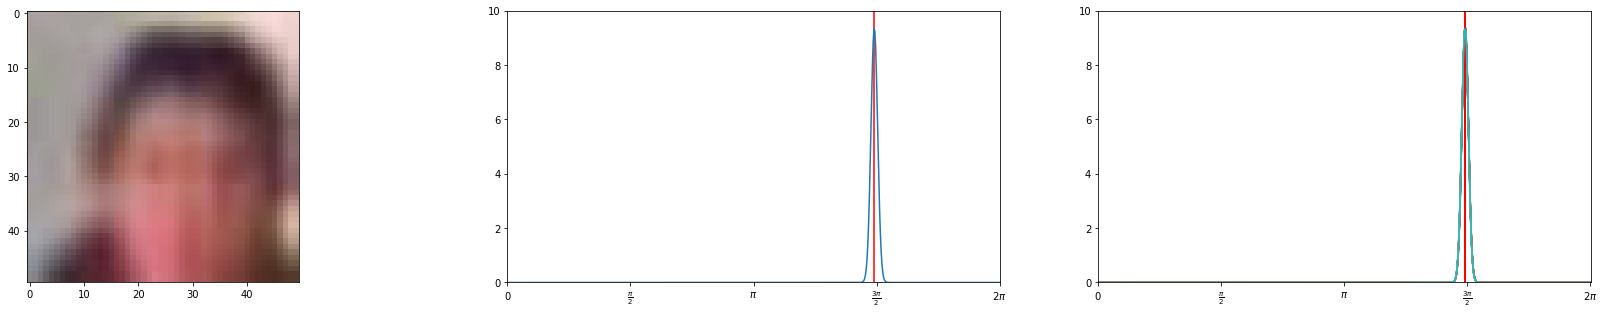

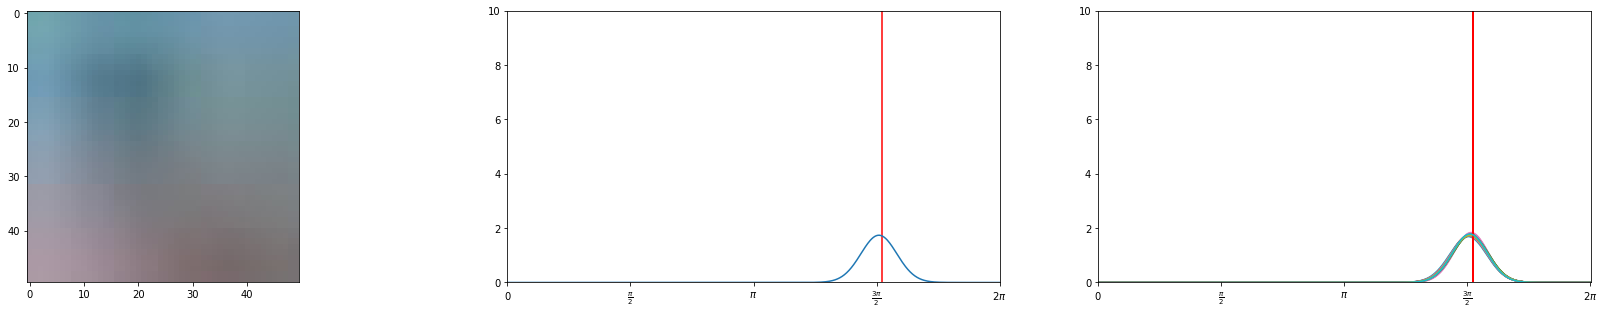

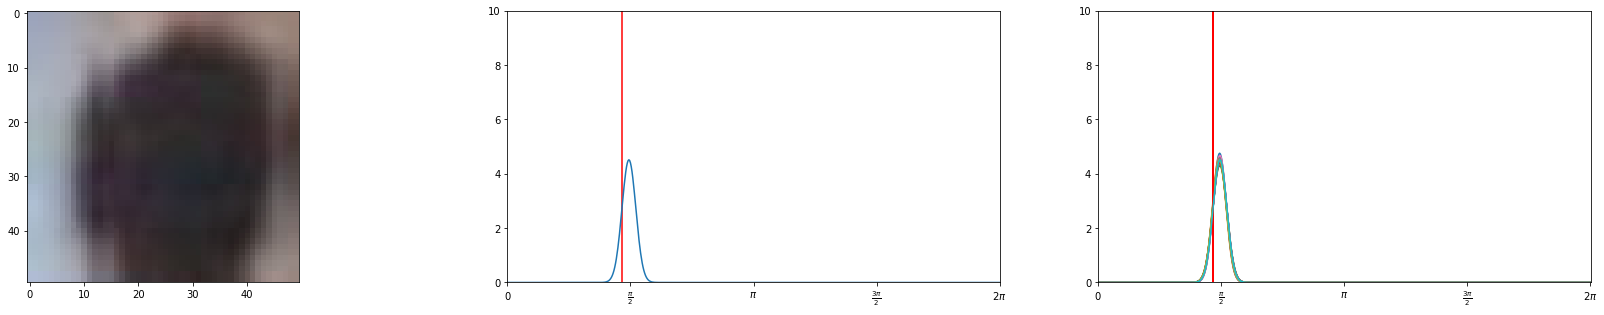

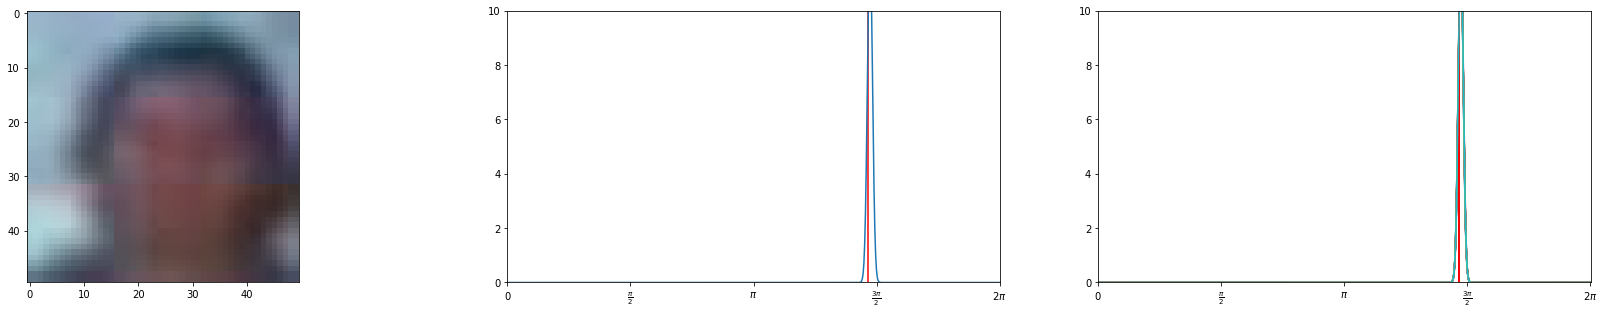

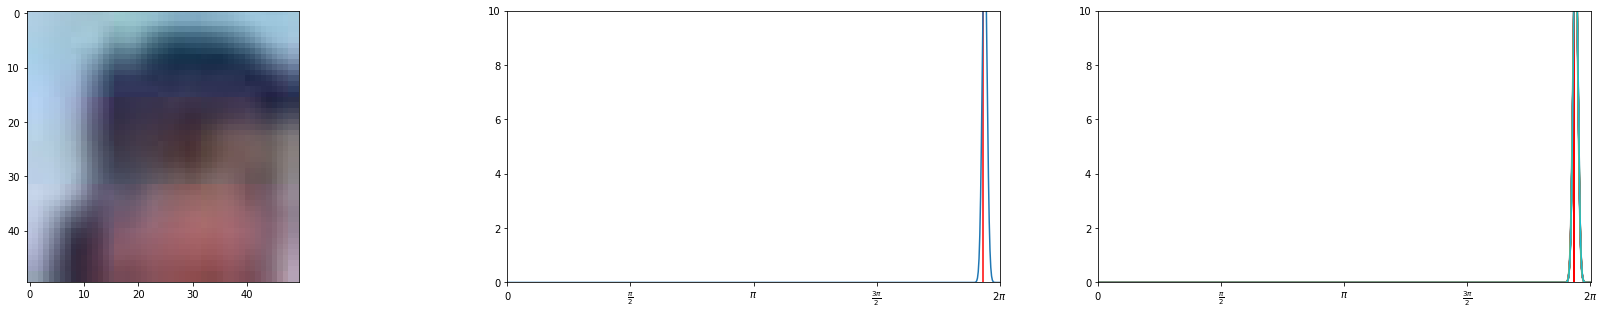

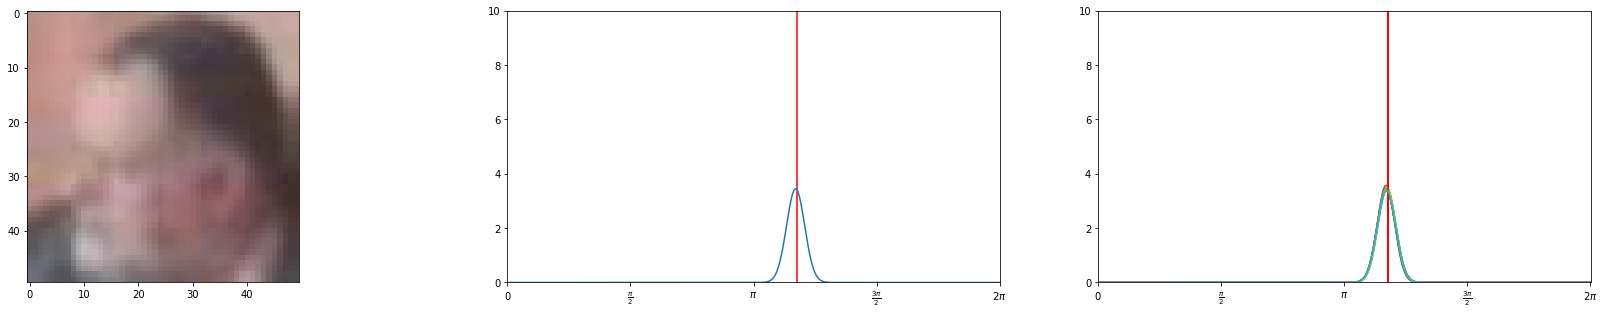

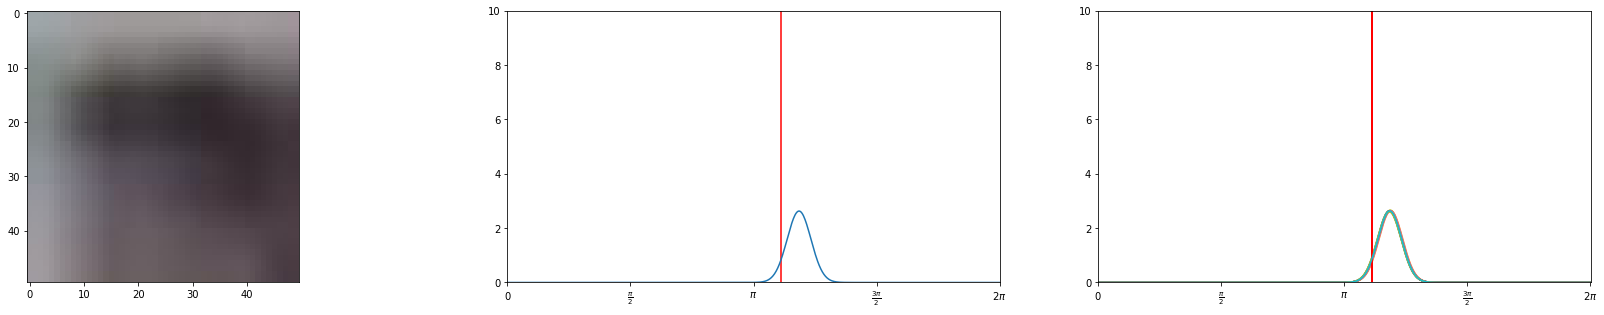

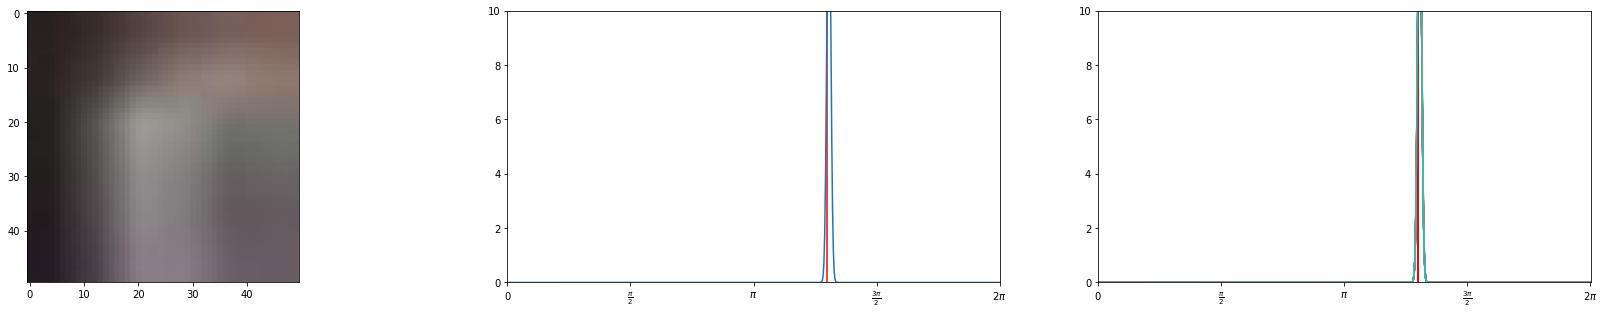

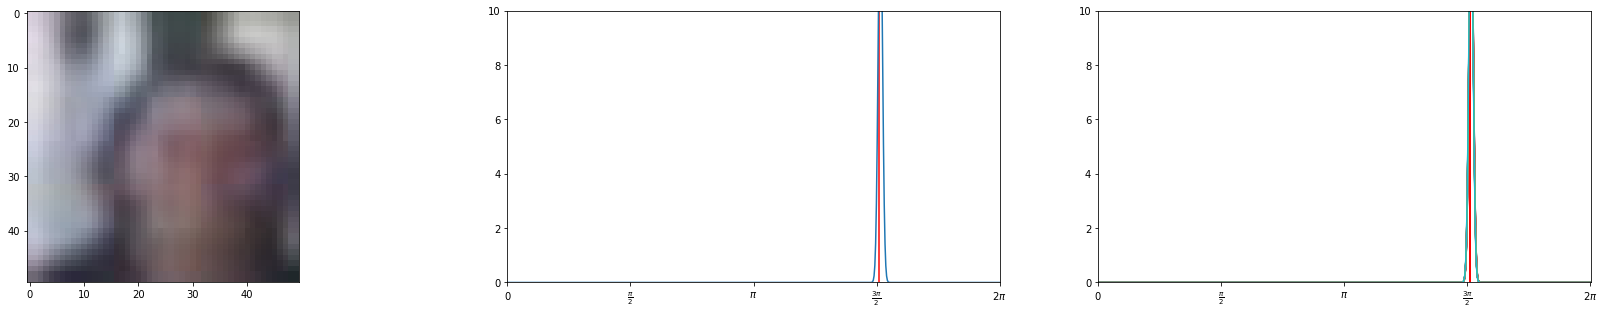

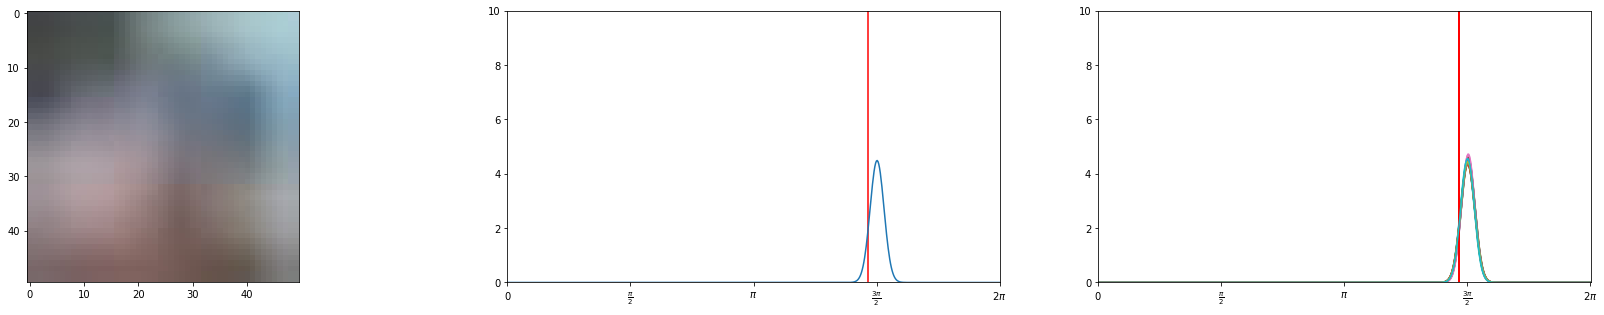

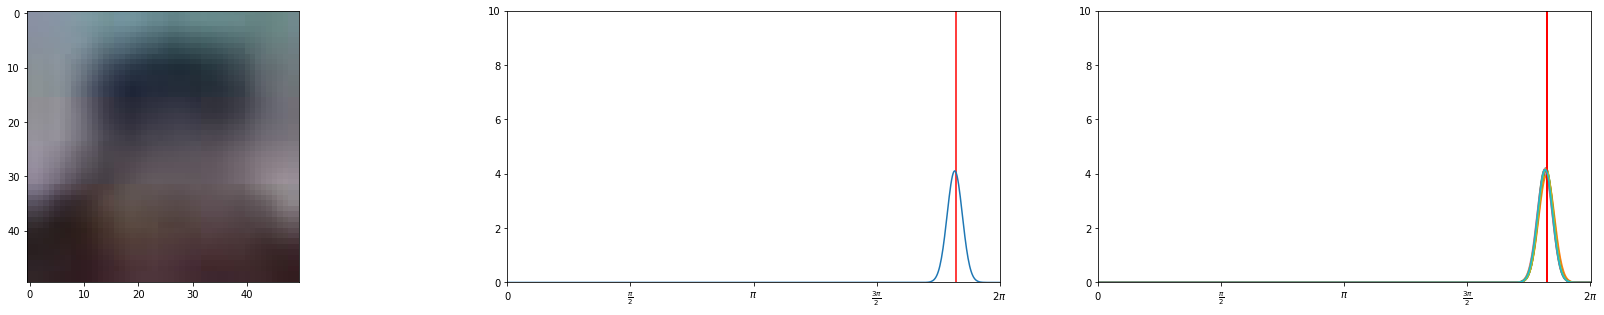

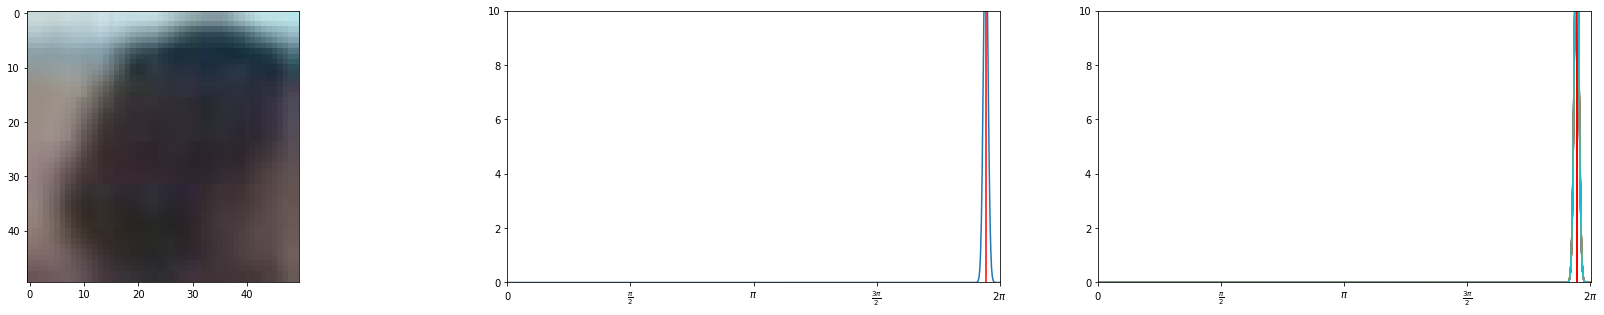

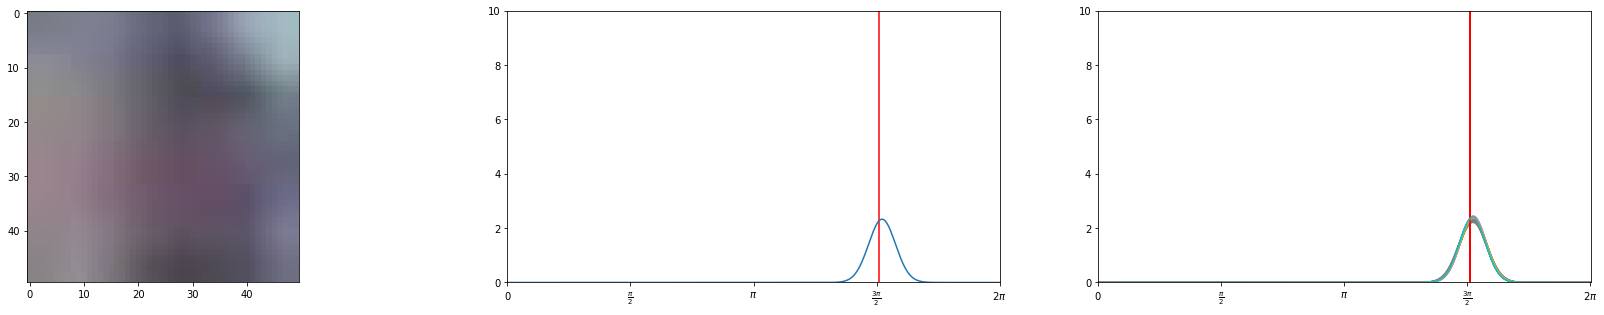

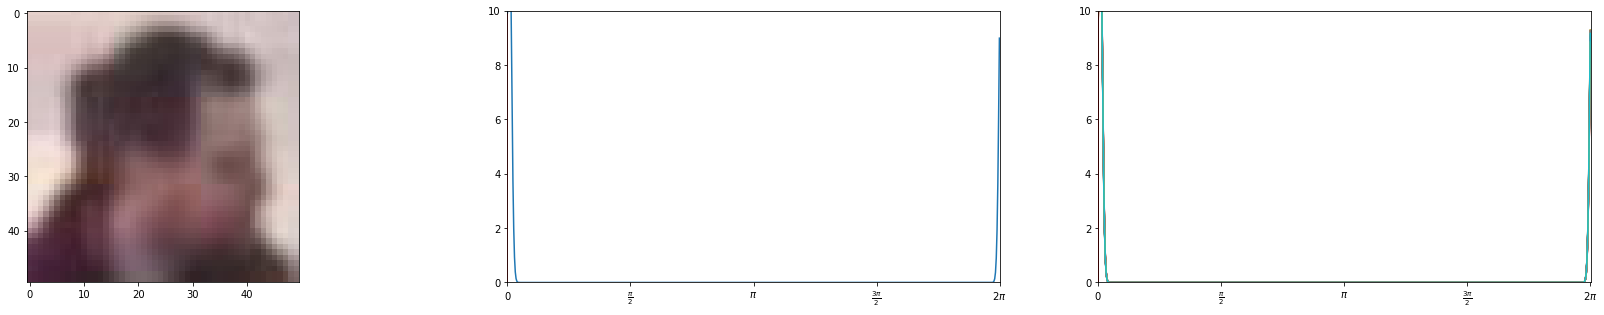

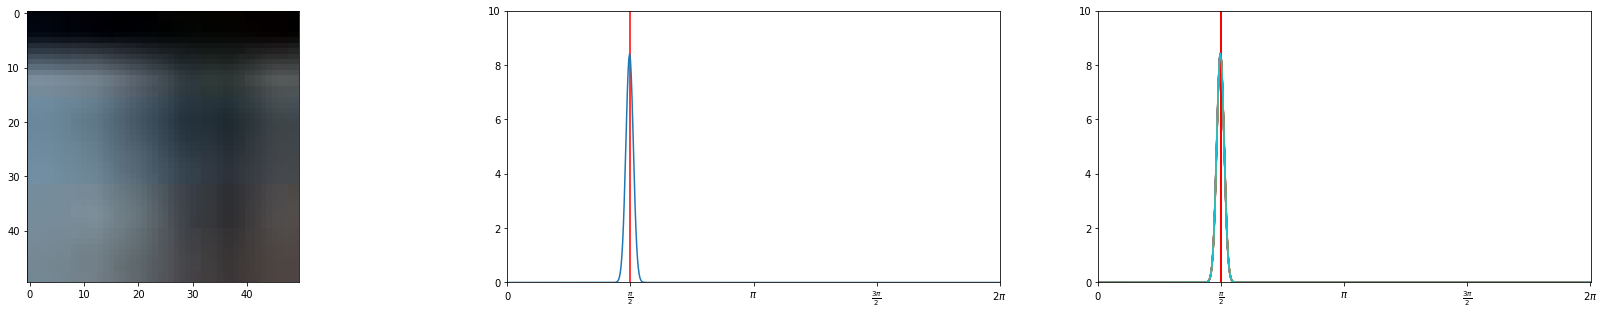

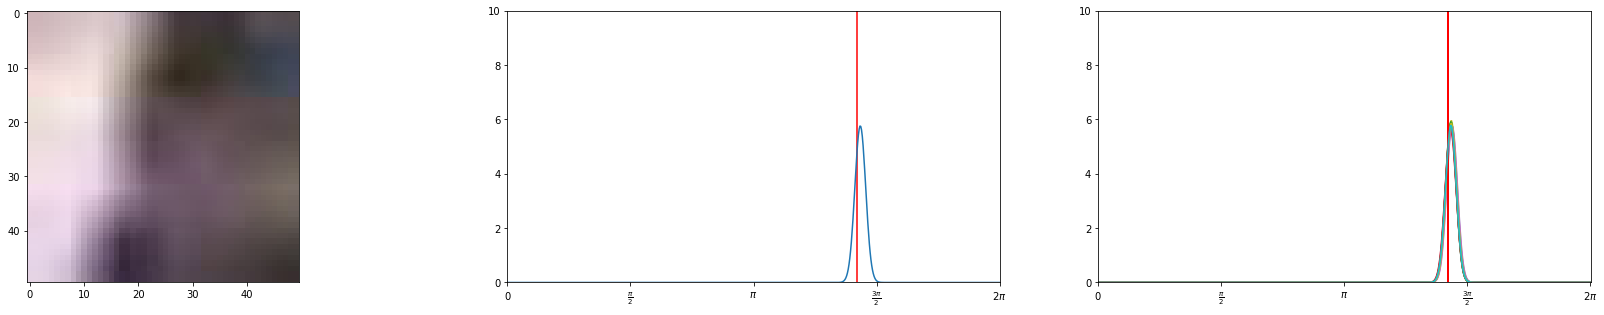

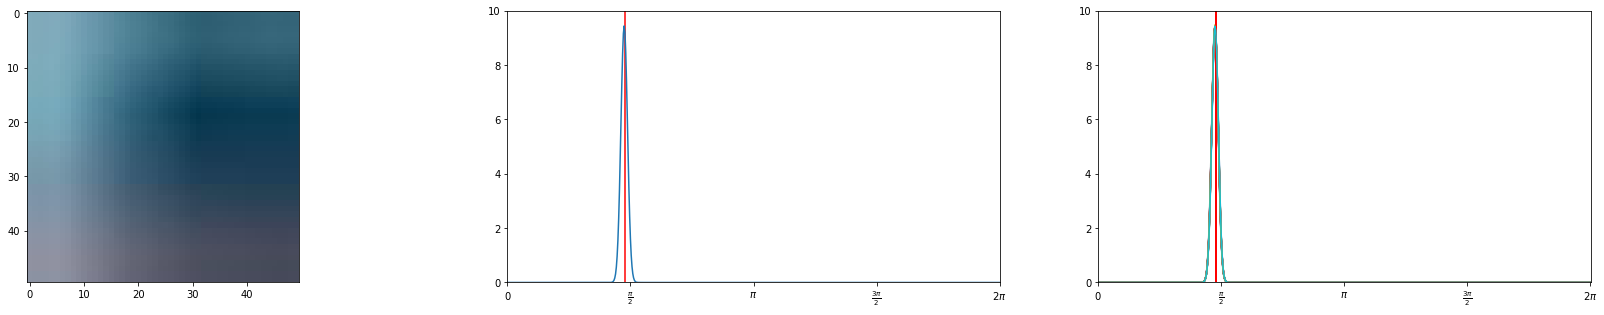

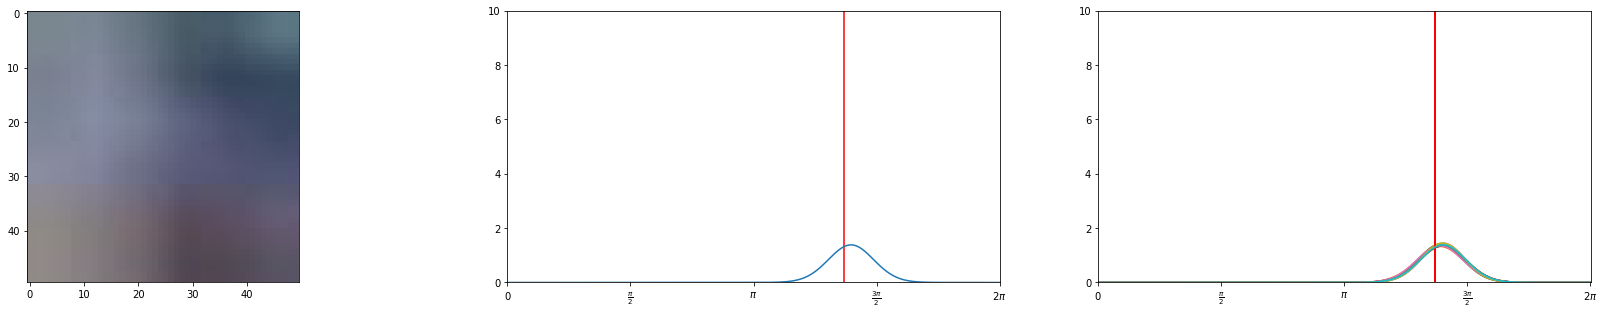

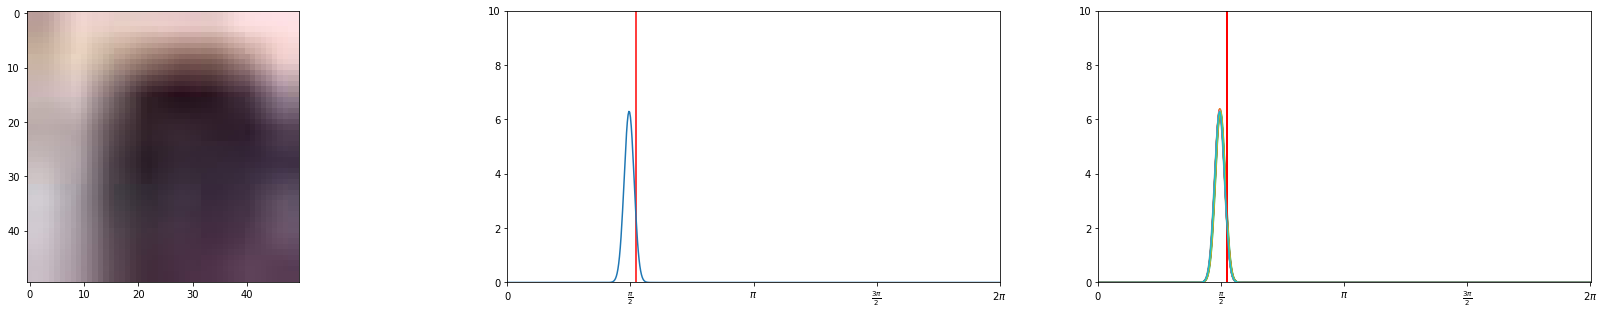

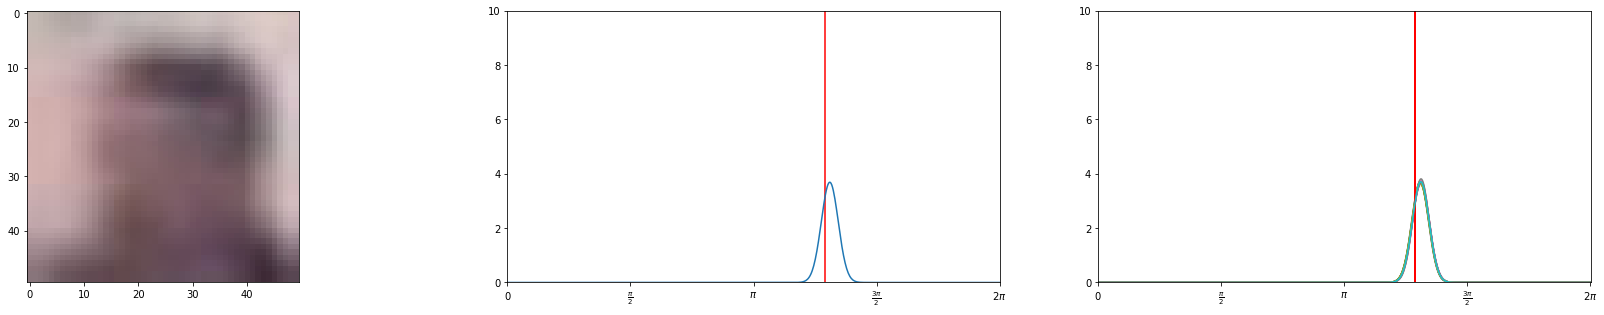

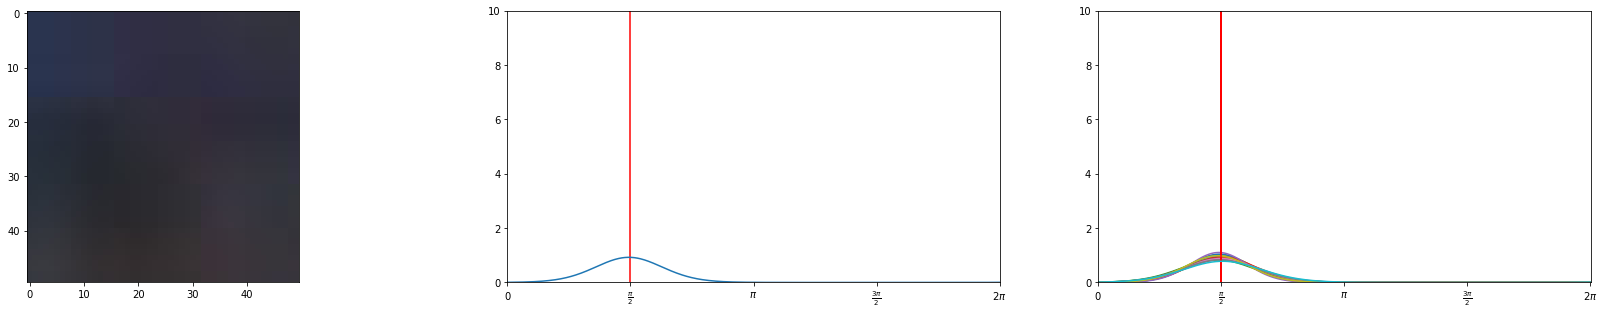

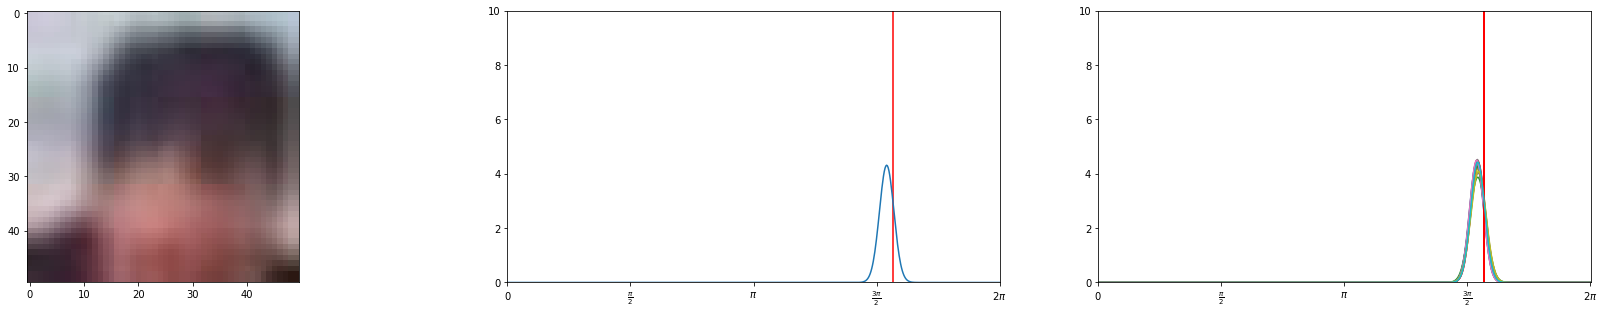

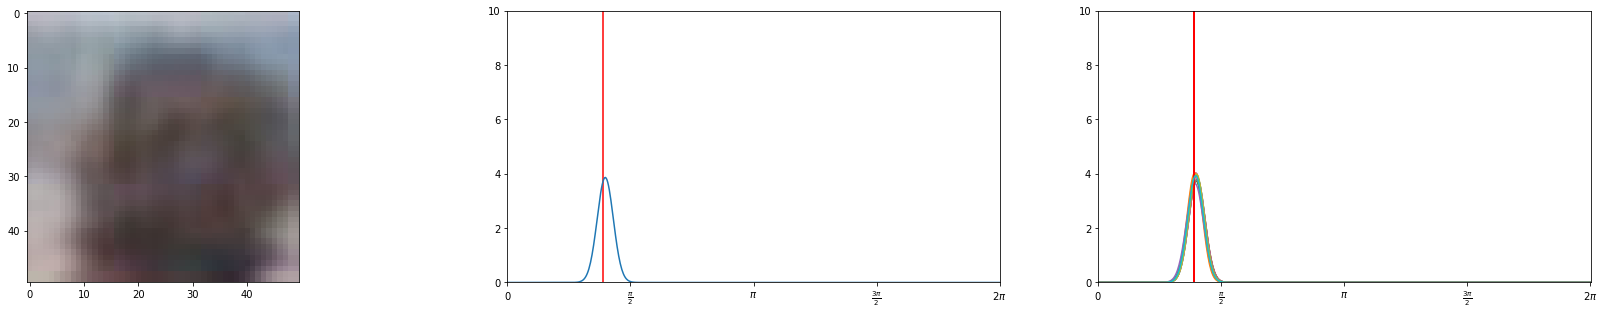

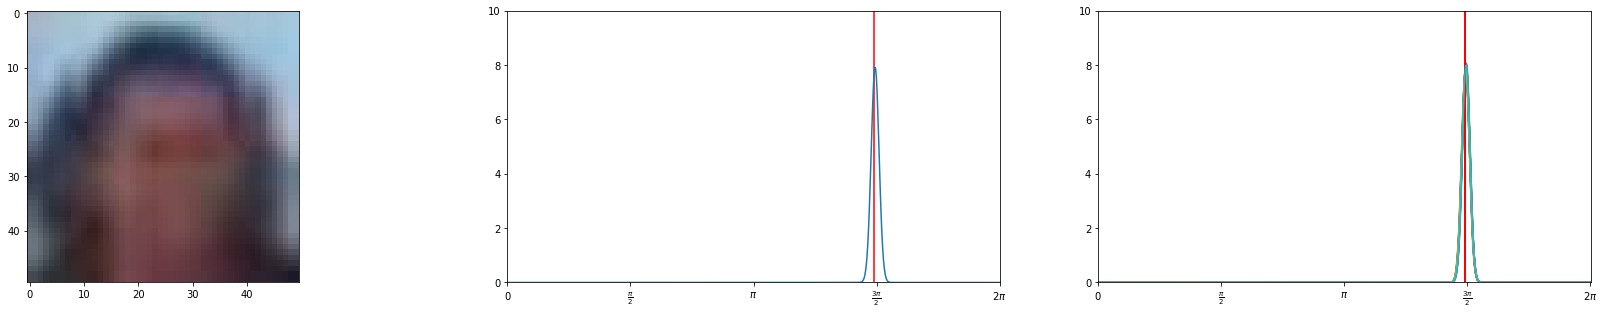

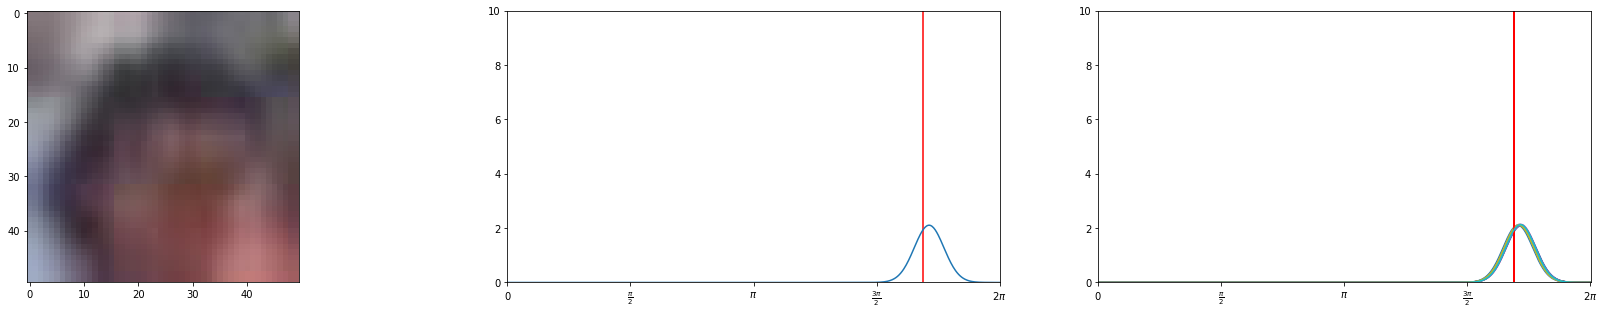

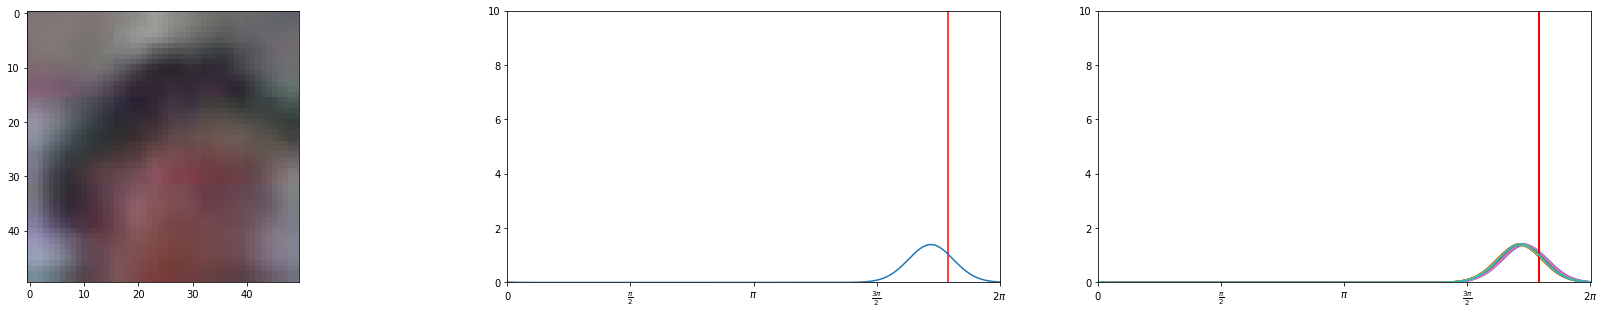

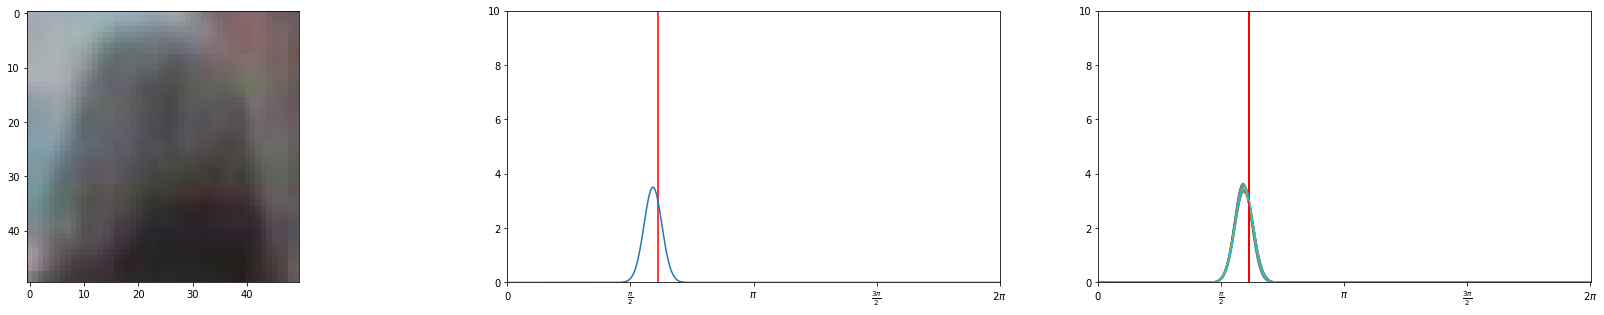

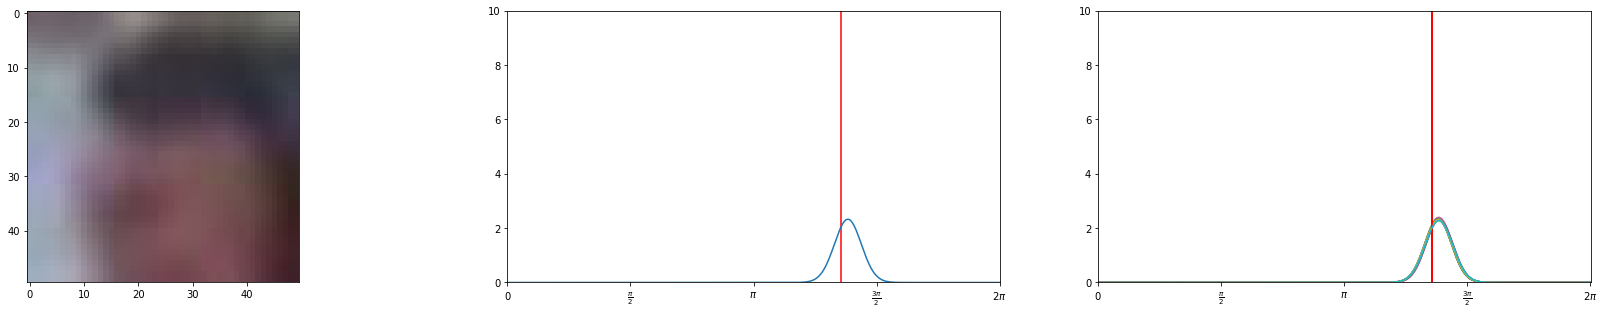

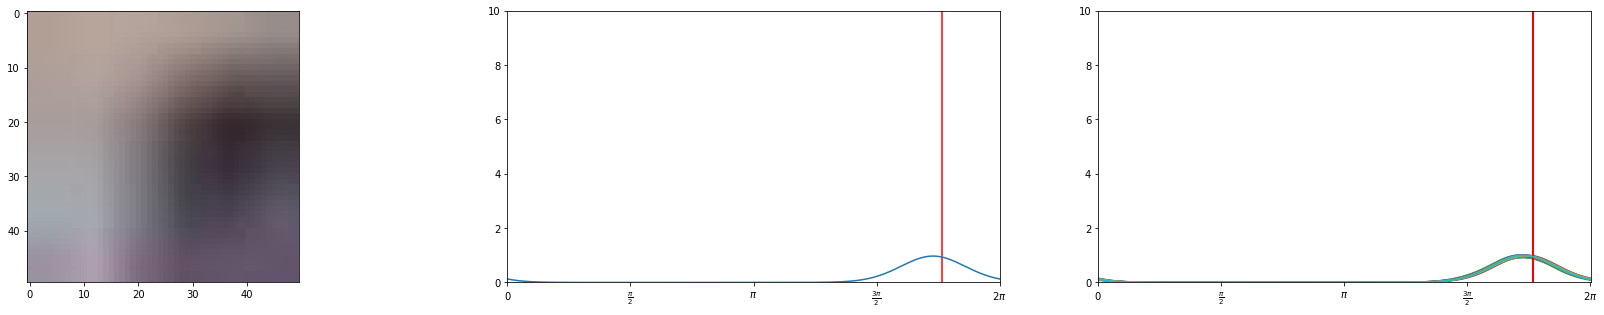

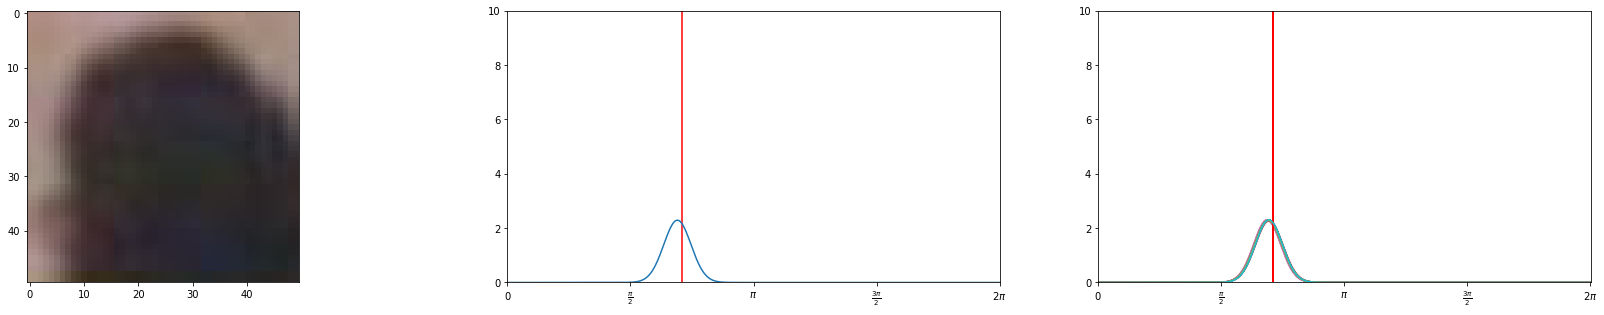

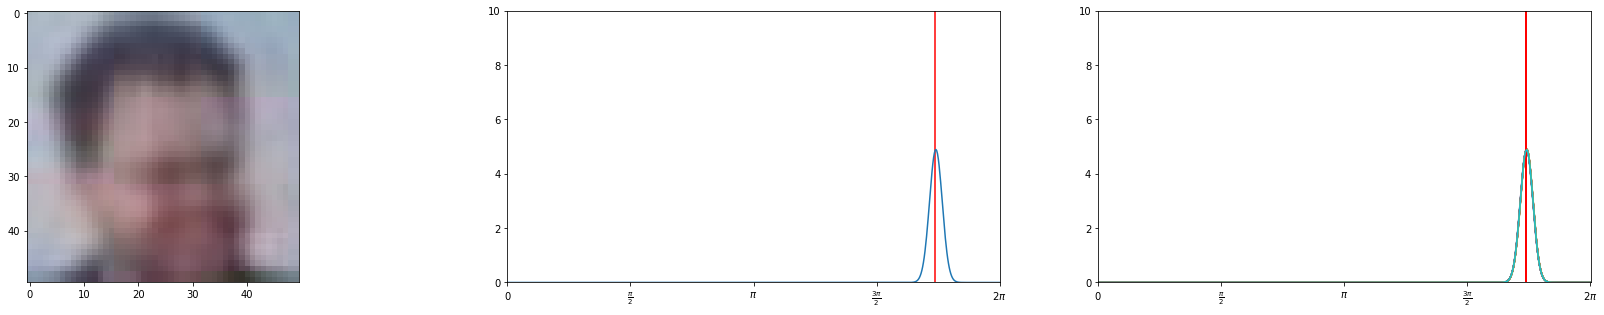

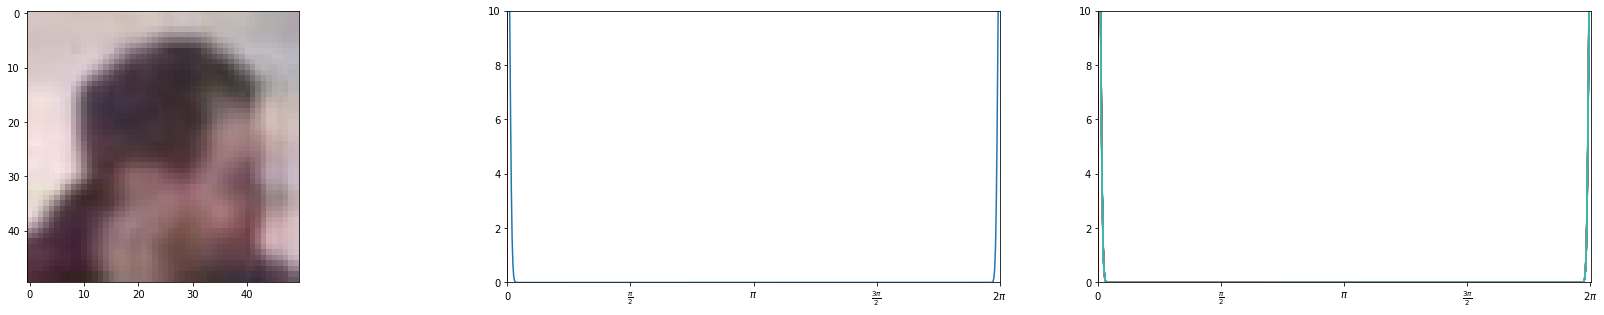

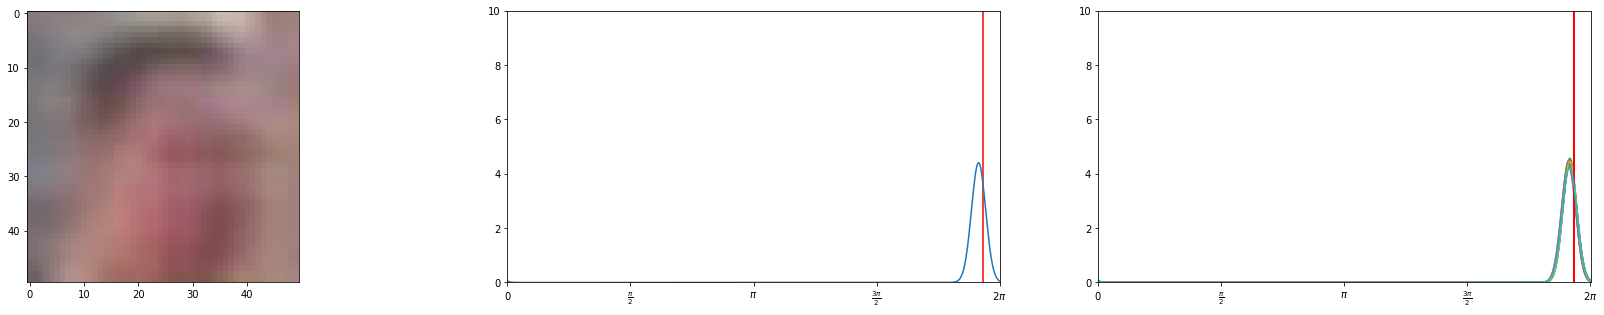

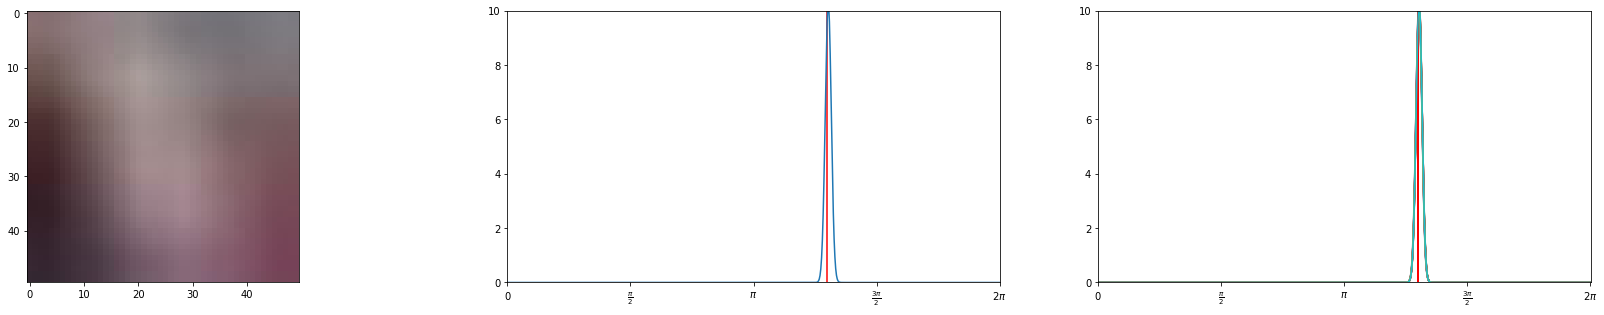

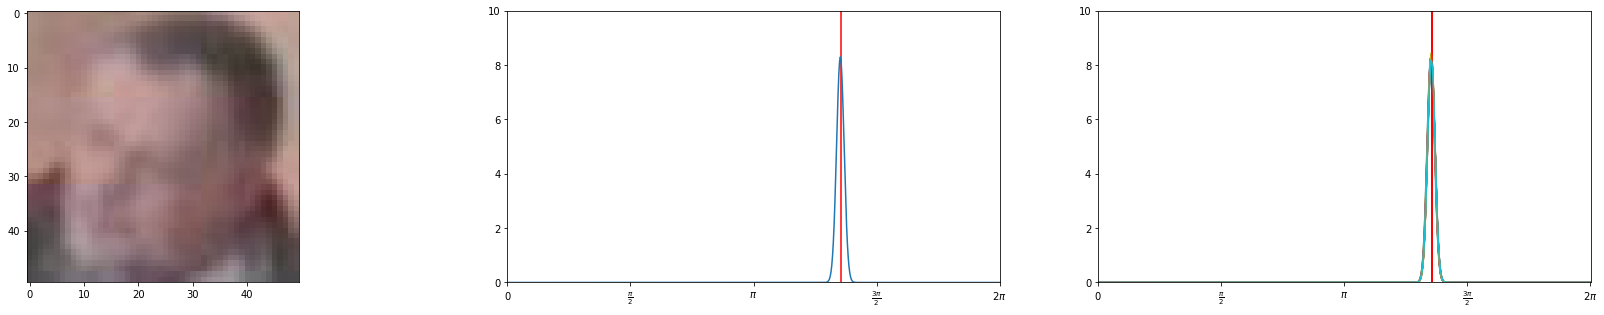

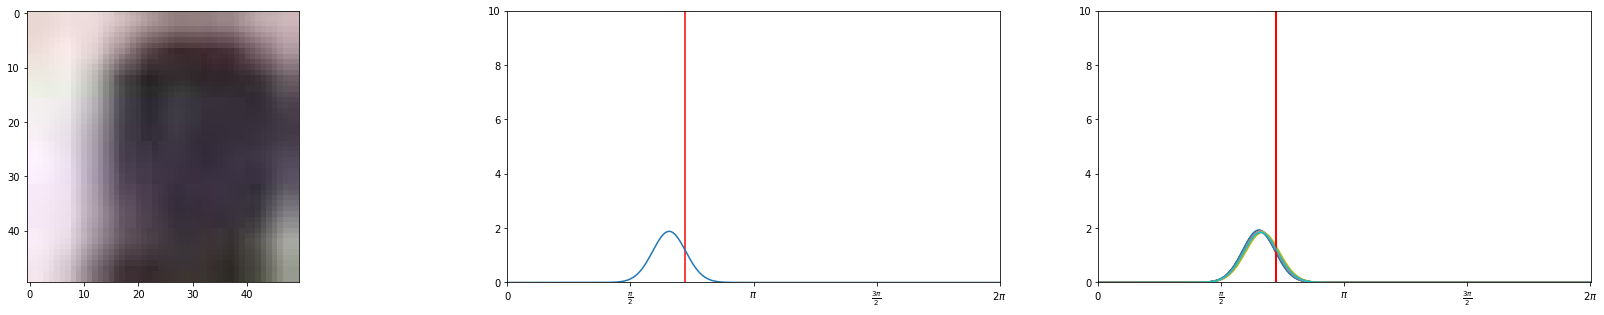

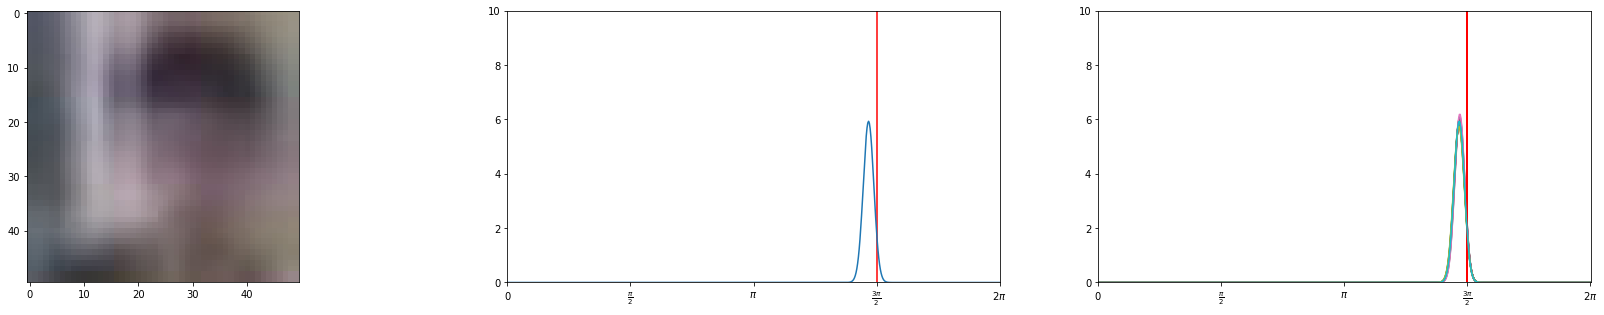

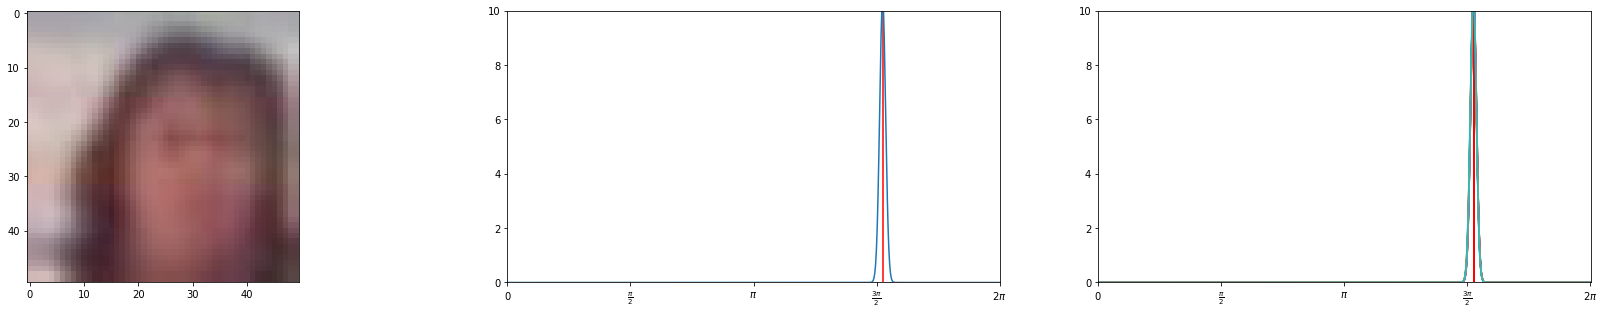

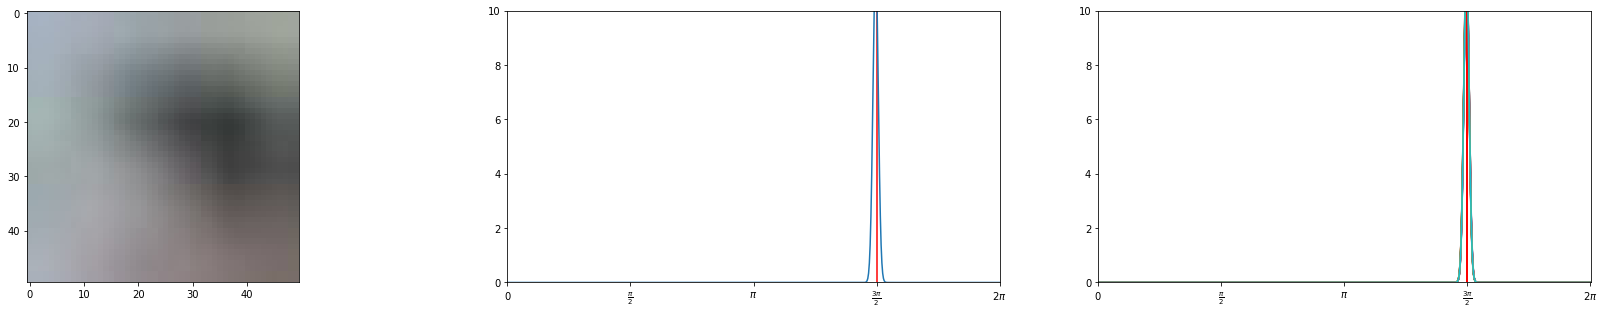

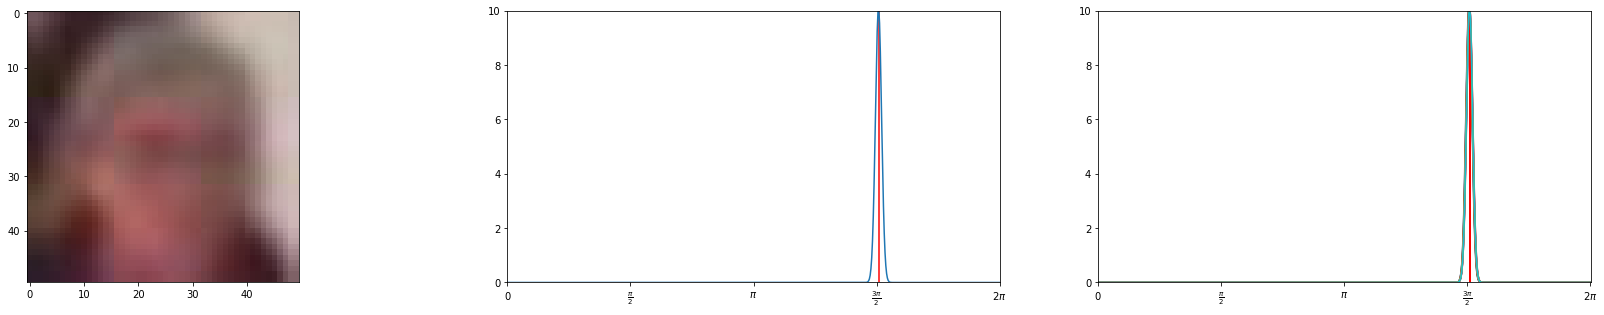

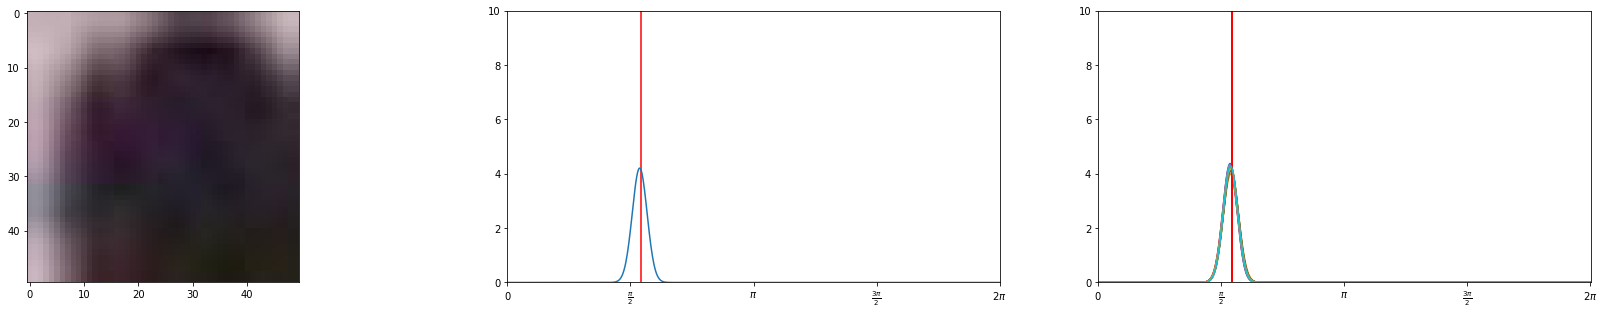

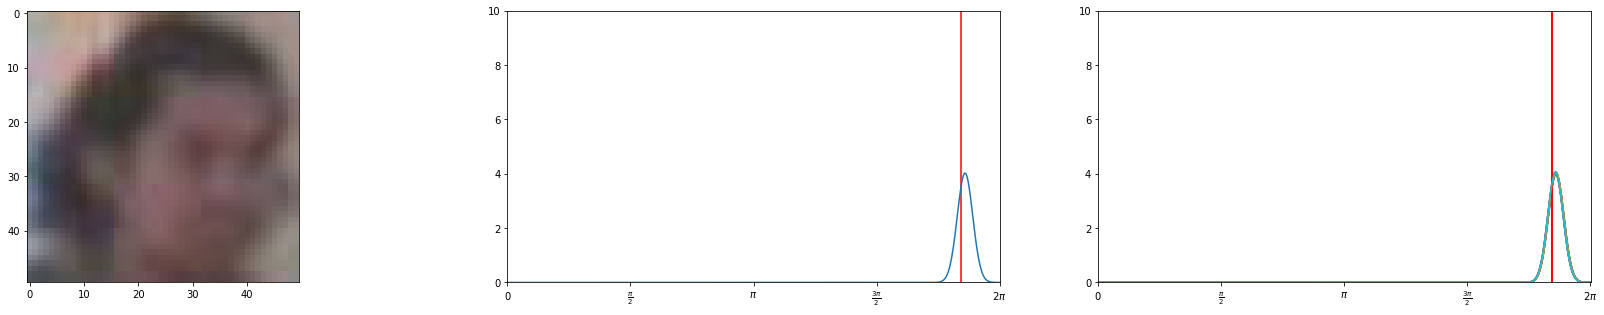

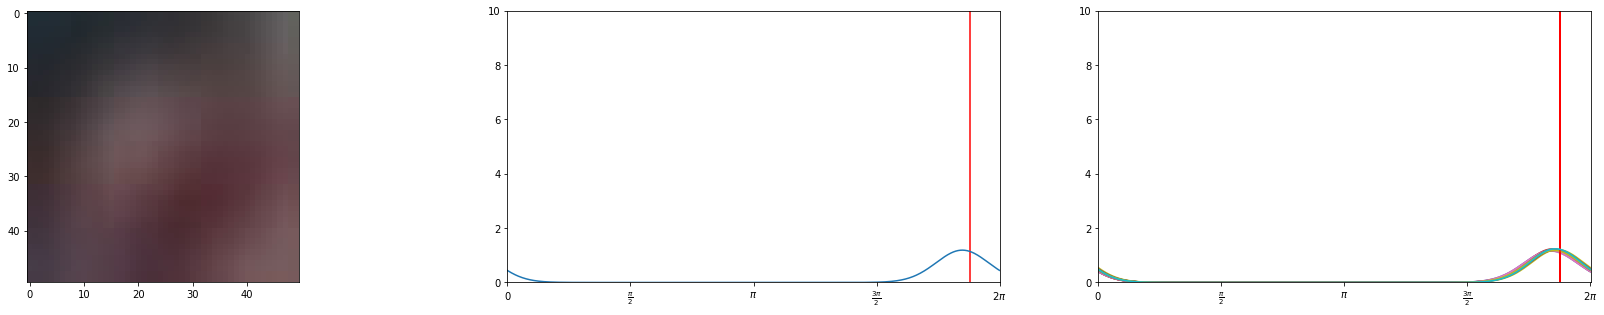

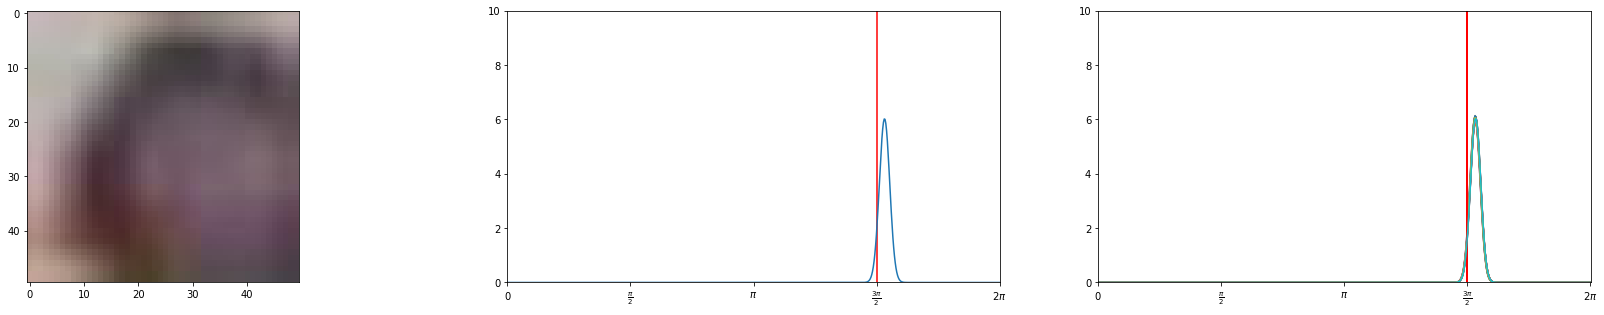

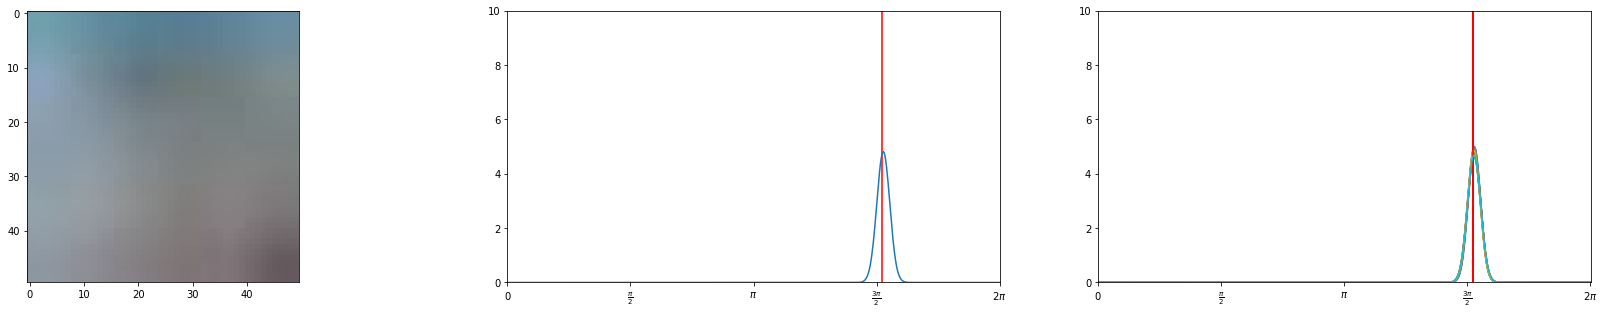

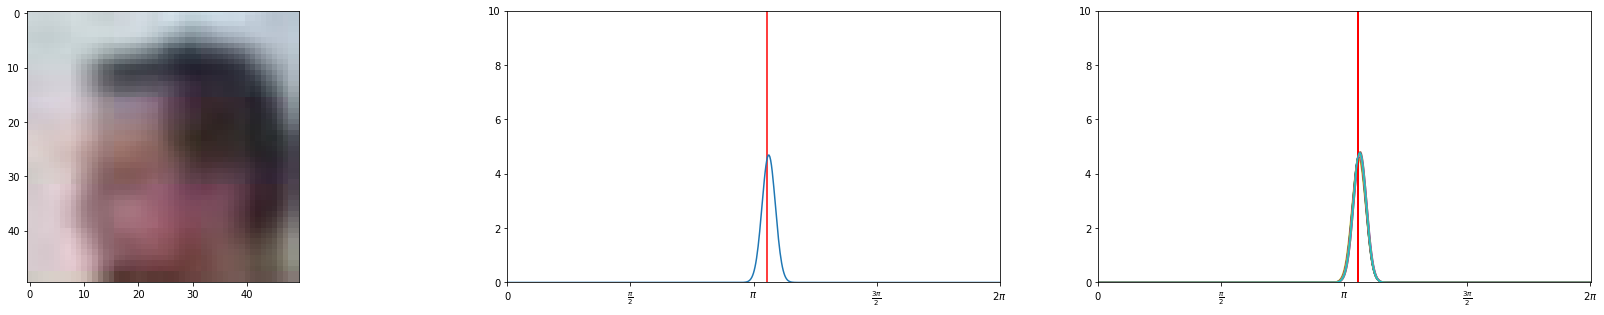

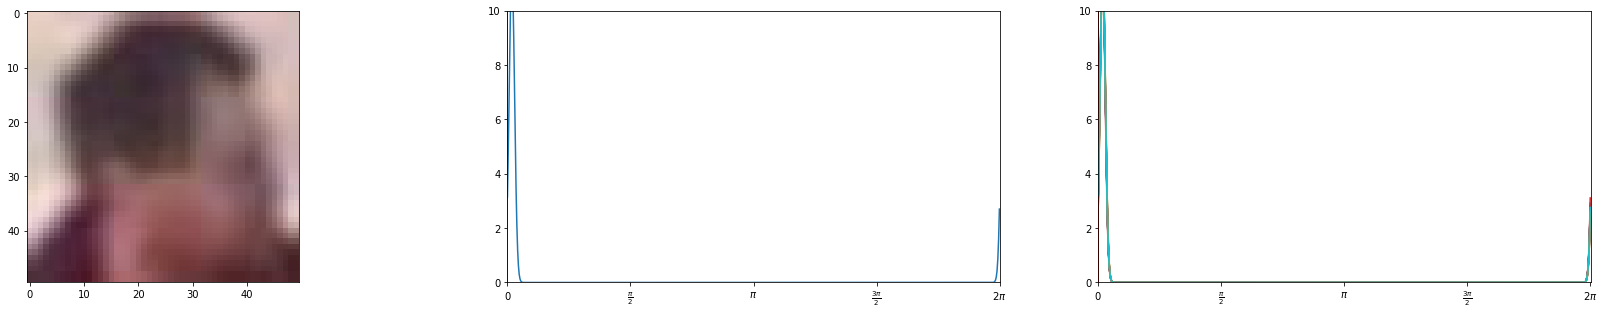

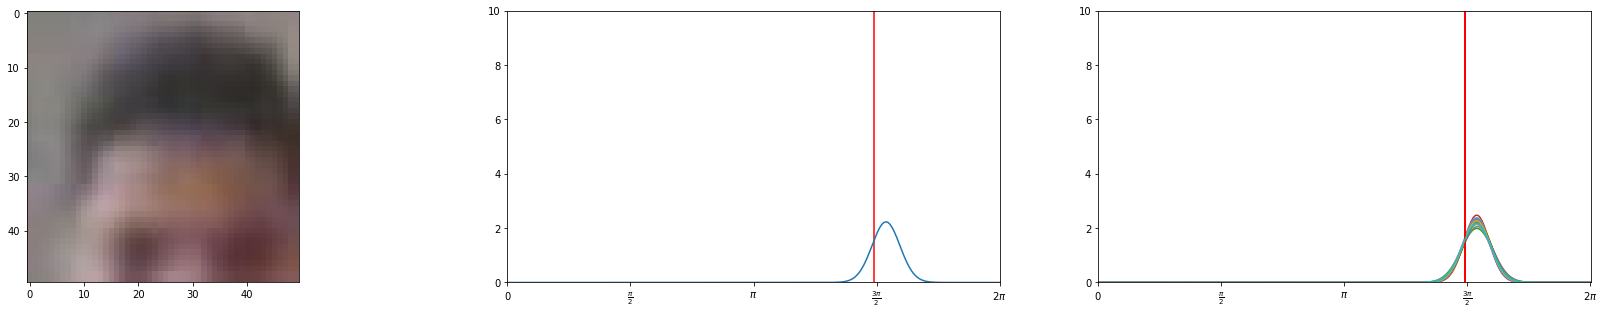

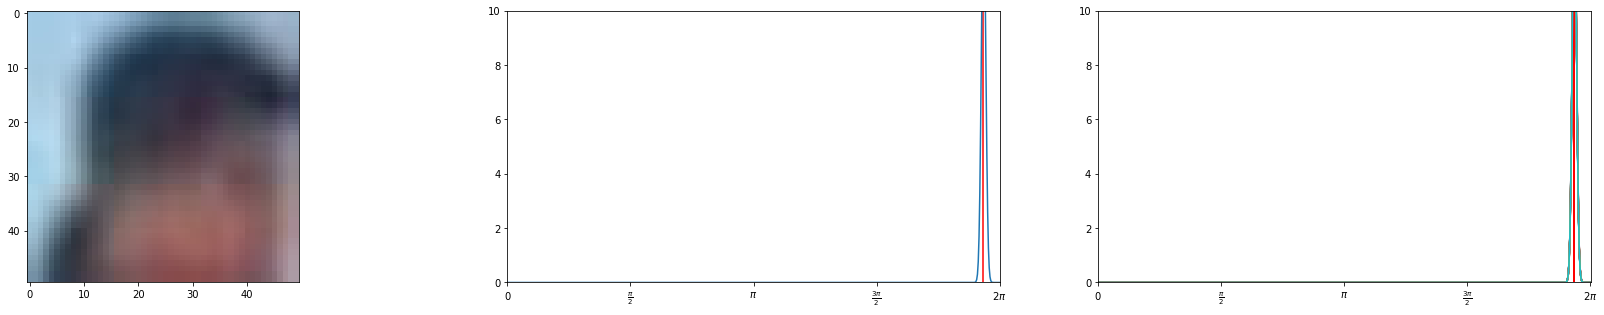

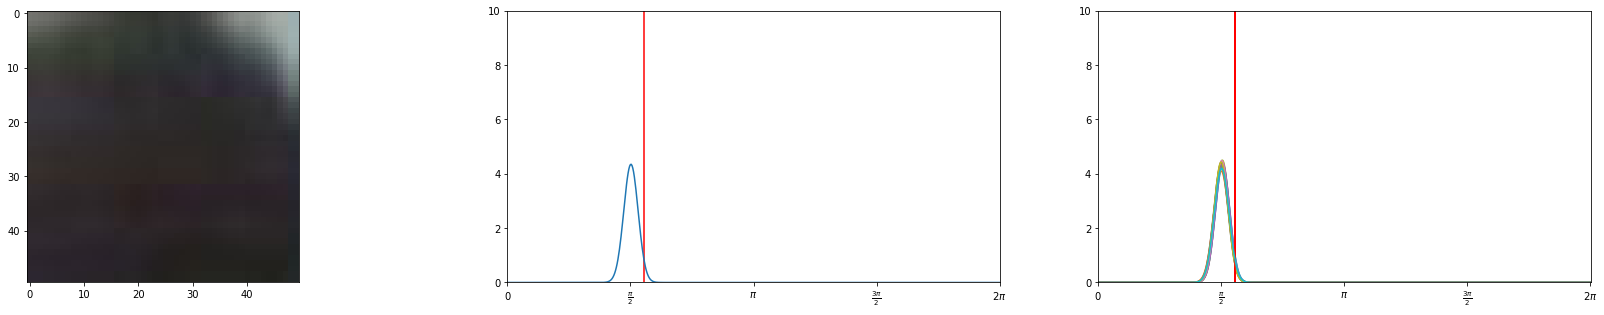

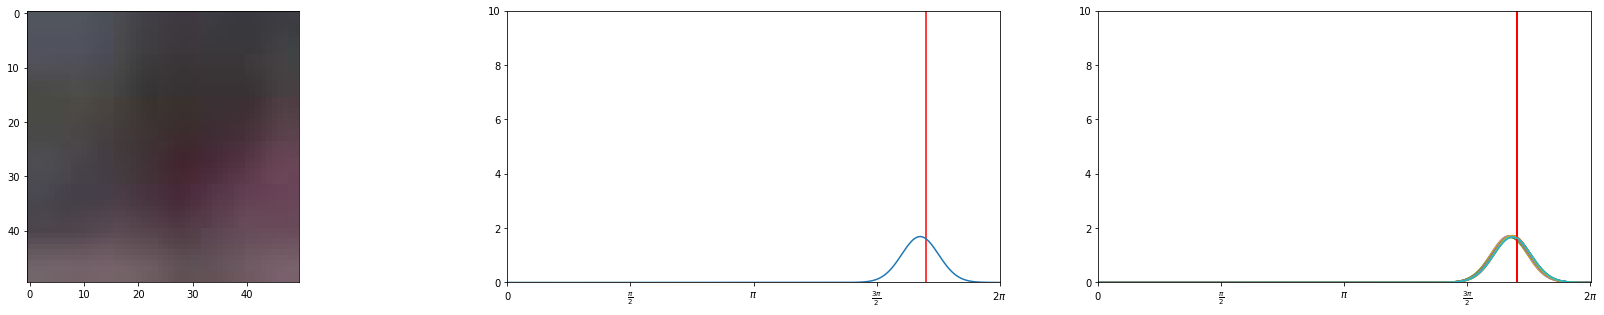

In [17]:
from utils.angles import bit2deg

yte_rad = np.deg2rad(bit2deg(yte_bit))

for fid in range(0, n_test_images):

    plot_image_results(xte[fid], xvals, cvae_acc_pdfs[fid], cvae_samples_pdfs[fid], yte_rad[fid])